# Sawyer Jacobson
## Data Science Capstone, Final Project
## Using Machine Learning to Predict NHL Game Outcomes

### 6/5/2021

This project will use data scraped from the NHL statsapi on the overall team and player levels to predict the outcome of regular season NHL games. 
This is a binary classification problem so the appropriate algorithms will be used. I am interested in obtaining the probability of 
winning for a team in the game as well. The target for predictions will be whether or not the home team won/will win and the associated probabilities.

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import plotnine
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy
from sklearn import metrics
import sklearn as sk
import re

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
player_stats = pd.read_csv("data/game_player_stats_full.csv")
goalie_stats = pd.read_csv("data/game_goalie_stats_full.csv")
game_results = pd.read_csv("data/game_results_full.csv")
team_stats_game = pd.read_csv("data/game_team_stats_full.csv")
officials_game = pd.read_csv("data/game_officials_full.csv")

# game_results = game_results.query("gameID <= 2019021082")
# team_stats_game = team_stats_game.query("gameID <= 2019021082")

## setting the ID columns to characters
# game results IDs
game_ID_cols = game_results.filter(like="ID").columns.to_list()
game_results[game_ID_cols] = game_results[game_ID_cols].astype(str)

# team stats IDs
ID_cols = team_stats_game.filter(like="ID").columns.to_list()
team_stats_game[ID_cols] = team_stats_game[ID_cols].astype(str)

# player stats IDs
player_ID_cols = player_stats.filter(like="ID").columns.to_list()
player_stats[player_ID_cols] = player_stats[player_ID_cols].astype(str)

# goalie stats IDs
goalie_ID_cols = goalie_stats.filter(like="ID").columns.to_list()
goalie_stats[goalie_ID_cols] = goalie_stats[goalie_ID_cols].astype(str)

# dropping periods played column. Not going to do much good right now
team_stats_game.drop(columns="periodsPlayed", inplace=True)

# converting game dateTime to a date
game_results["dateTime"] = pd.to_datetime(game_results.dateTime).dt.date

player_stats.shape
goalie_stats.shape
game_results.shape
team_stats_game.shape
officials_game.shape

(453237, 27)

(27104, 24)

(12592, 12)

(25181, 17)

(50422, 3)

# Exploratory data analysis

First we'll check to see that all the data game in in the proper format. Some of the player ice time columns will need to be fixed using the function used for the player analysis project.

Also check to see what data is missing. Since I collected the data in a specific manner, missing data should be just the absence of data and in most cases will mean 0, False, whatever is the appropriate base case for that type of variable.

Since our interest is in the game data, let's see how the games are distributed in terms of results and scoring.

In [3]:
pd.set_option("max_info_columns", player_stats.shape[1])
pd.set_option("max_columns", player_stats.shape[1])

# checking the data types of each column to see what else needs to be cleaned
player_stats.info()
goalie_stats.info()
game_results.info()
team_stats_game.info()
officials_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453237 entries, 0 to 453236
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gameID                453237 non-null  object 
 1   playerID              453237 non-null  object 
 2   fullName              453237 non-null  object 
 3   position              453237 non-null  object 
 4   homeAway              453237 non-null  object 
 5   teamID                453237 non-null  object 
 6   teamName              453237 non-null  object 
 7   timeOnIce             453237 non-null  object 
 8   assists               453237 non-null  int64  
 9   goals                 453237 non-null  int64  
 10  shots                 453237 non-null  int64  
 11  hits                  453237 non-null  int64  
 12  powerPlayGoals        453237 non-null  int64  
 13  powerPlayAssists      453237 non-null  int64  
 14  penaltyMinutes        453237 non-null  int64  
 15  

Looks like everythink actually came in pretty clean! The time on ice variables need to be fixed as expected, but everything else came through nicely!

In [4]:
player_stats.columns

Index(['gameID', 'playerID', 'fullName', 'position', 'homeAway', 'teamID',
       'teamName', 'timeOnIce', 'assists', 'goals', 'shots', 'hits',
       'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins',
       'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals',
       'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce',
       'powerPlayTimeOnIce', 'shortHandedTimeOnIce', 'faceOffPct'],
      dtype='object')

In [5]:
player_stats.head()

,gameID,playerID,fullName,position,homeAway,teamID,teamName,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,powerPlayTimeOnIce,shortHandedTimeOnIce,faceOffPct
0,2010020001,8468778,Colton Orr,R,home,10,Toronto Maple Leafs,3:19,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,3:19,0:00,0:00,NaN
1,2010020001,8470602,Dion Phaneuf,D,home,10,Toronto Maple Leafs,23:45,1,0,2,2,0,0,2,0,0,0,1,0,0,3,1,15:11,6:47,1:47,NaN
2,2010020001,8465200,Tomas Kaberle,D,home,10,Toronto Maple Leafs,23:55,0,0,2,1,0,0,0,0,0,0,0,0,0,2,0,16:16,7:39,0:00,NaN
3,2010020001,8467400,Francois Beauchemin,D,home,10,Toronto Maple Leafs,22:21,0,0,1,3,0,0,0,0,0,1,2,0,0,3,0,15:42,3:25,3:14,NaN
4,2010020001,8474125,Carl Gunnarsson,D,home,10,Toronto Maple Leafs,17:33,0,0,1,1,0,0,0,0,0,1,3,0,0,2,1,13:19,1:28,2:46,NaN


In [6]:
team_stats_game.tail()

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits
25176,2020020866,away,True,Craig Berube,19,St. Louis Blues,1,12,21,0.0,0.0,3.0,57.1,18,9,11,42
25177,2020020867,home,False,Todd McLellan,26,Los Angeles Kings,2,6,18,0.0,0.0,2.0,57.8,12,1,7,23
25178,2020020867,away,False,Jared Bednar,21,Colorado Avalanche,3,4,30,33.3,1.0,3.0,42.2,13,5,9,30
25179,2020020868,home,False,Bob Boughner,28,San Jose Sharks,4,6,48,0.0,0.0,2.0,48.4,6,7,12,12
25180,2020020868,away,False,Rick Tocchet,53,Arizona Coyotes,5,6,32,50.0,1.0,2.0,51.6,8,6,9,13


In [7]:
game_results.tail()

,gameID,season,dateTime,gameType,homeTeamID,homeTeamName,awayTeamID,awayTeamName,homeGoals,awayGoals,homeTeamWin,venue
12587,2020020864,20202021,2021-05-18,R,23,Vancouver Canucks,20,Calgary Flames,4,2,True,Rogers Arena
12588,2020020865,20202021,2021-05-09,R,30,Minnesota Wild,24,Anaheim Ducks,4,3,True,Xcel Energy Center
12589,2020020866,20202021,2021-05-09,R,54,Vegas Golden Knights,19,St. Louis Blues,4,1,True,T-Mobile Arena
12590,2020020867,20202021,2021-05-09,R,26,Los Angeles Kings,21,Colorado Avalanche,2,3,False,STAPLES Center
12591,2020020868,20202021,2021-05-09,R,28,San Jose Sharks,53,Arizona Coyotes,4,5,False,SAP Center at San Jose


In [8]:
# percentage of games where the home team won
game_results.homeTeamWin.value_counts()/game_results.shape[0]

def add_season(df):
    return df['gameID'].astype(str).str[0:4] + "/" + (df['gameID'].astype(str).str[0:4].astype(int) + 1).astype(str)

# adding a season column
game_results["season"] = add_season(game_results)#game_results['gameID'].astype(str).str[0:4] + "/" + (game_results['gameID'].astype(str).str[0:4].astype(int) + 1).astype(str)

True     0.542964
False    0.457036
Name: homeTeamWin, dtype: float64

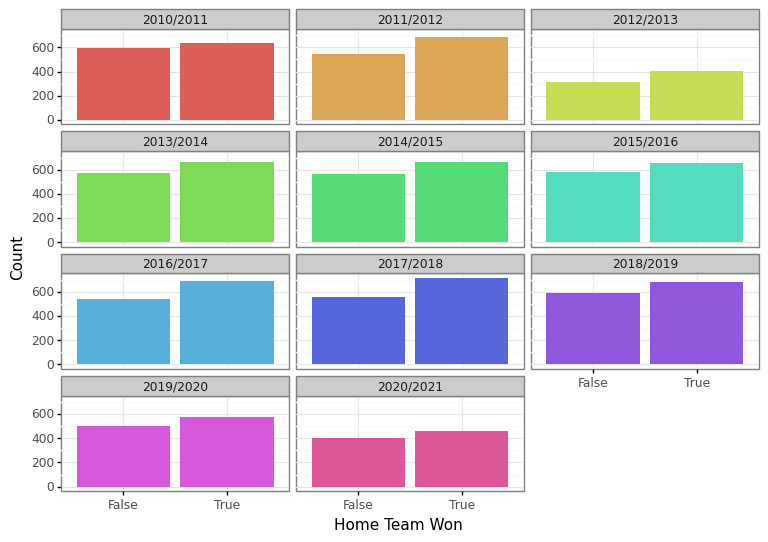

<ggplot: (345558525)>

In [9]:
plotnine.options.figure_size = (9, 6)

(
ggplot(game_results, aes(x = "homeTeamWin", fill = 'season')) + 
    geom_bar() + 
    theme_bw() + 
    facet_wrap(" ~ season", ncol = 3) +
    scale_fill_discrete(guide=False) +
    labs(x = "Home Team Won", y = "Count")
)

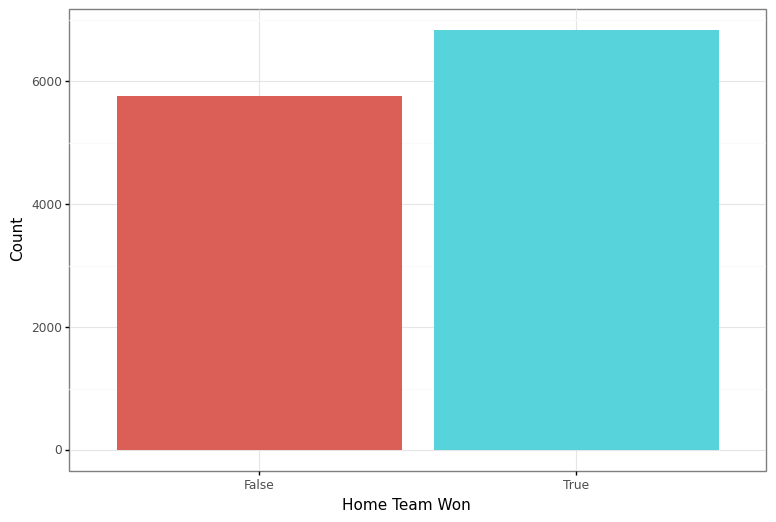

<ggplot: (352168274)>

In [10]:
(
ggplot(game_results, aes(x = "homeTeamWin", fill = "homeTeamWin")) + 
    geom_bar() + 
    theme_bw() + 
    scale_fill_discrete(guide=False) +
    labs(x = "Home Team Won", y = "Count")
)

In [11]:
pd.crosstab(index=game_results['season'], columns=game_results['homeTeamWin'])

game_results['homeTeamWin'].value_counts()/game_results.shape[0]

homeTeamWin,False,True
season,,
2010/2011,592,638
2011/2012,543,687
2012/2013,311,409
2013/2014,570,660
2014/2015,564,666
2015/2016,579,651
2016/2017,542,688
2017/2018,555,716
2018/2019,589,682


True     0.542964
False    0.457036
Name: homeTeamWin, dtype: float64

In almost every season from the past decade, the home team has won a slight majority of the games. 

Below, we'll create a new dataset that has a teams cumulative statistics throughout a season. These stats will be used as features in the predictive model. The difference between 2 teams cumulative stats up to the desired game in a season will be used (home team - away team) which should help determine which team is doing better in that season as well as a certain difference in performance. I would like to include other features such as whether the starter goalie has played consecutive games or not and also take into account the roster for each team, but that might not be feasible based on the time constraints for this project. This last feature would be something of a pseudo roster strength going into the game. Theoretically this could help because the roster strength would be diminished if a star player was out hurt or something. Alternatively, I will use the number of players on point streaks as well as win and losing streaks for the teams.

In [12]:
common_venues = pd.DataFrame(game_results["venue"].value_counts()).query("venue >= 50").index.to_list()

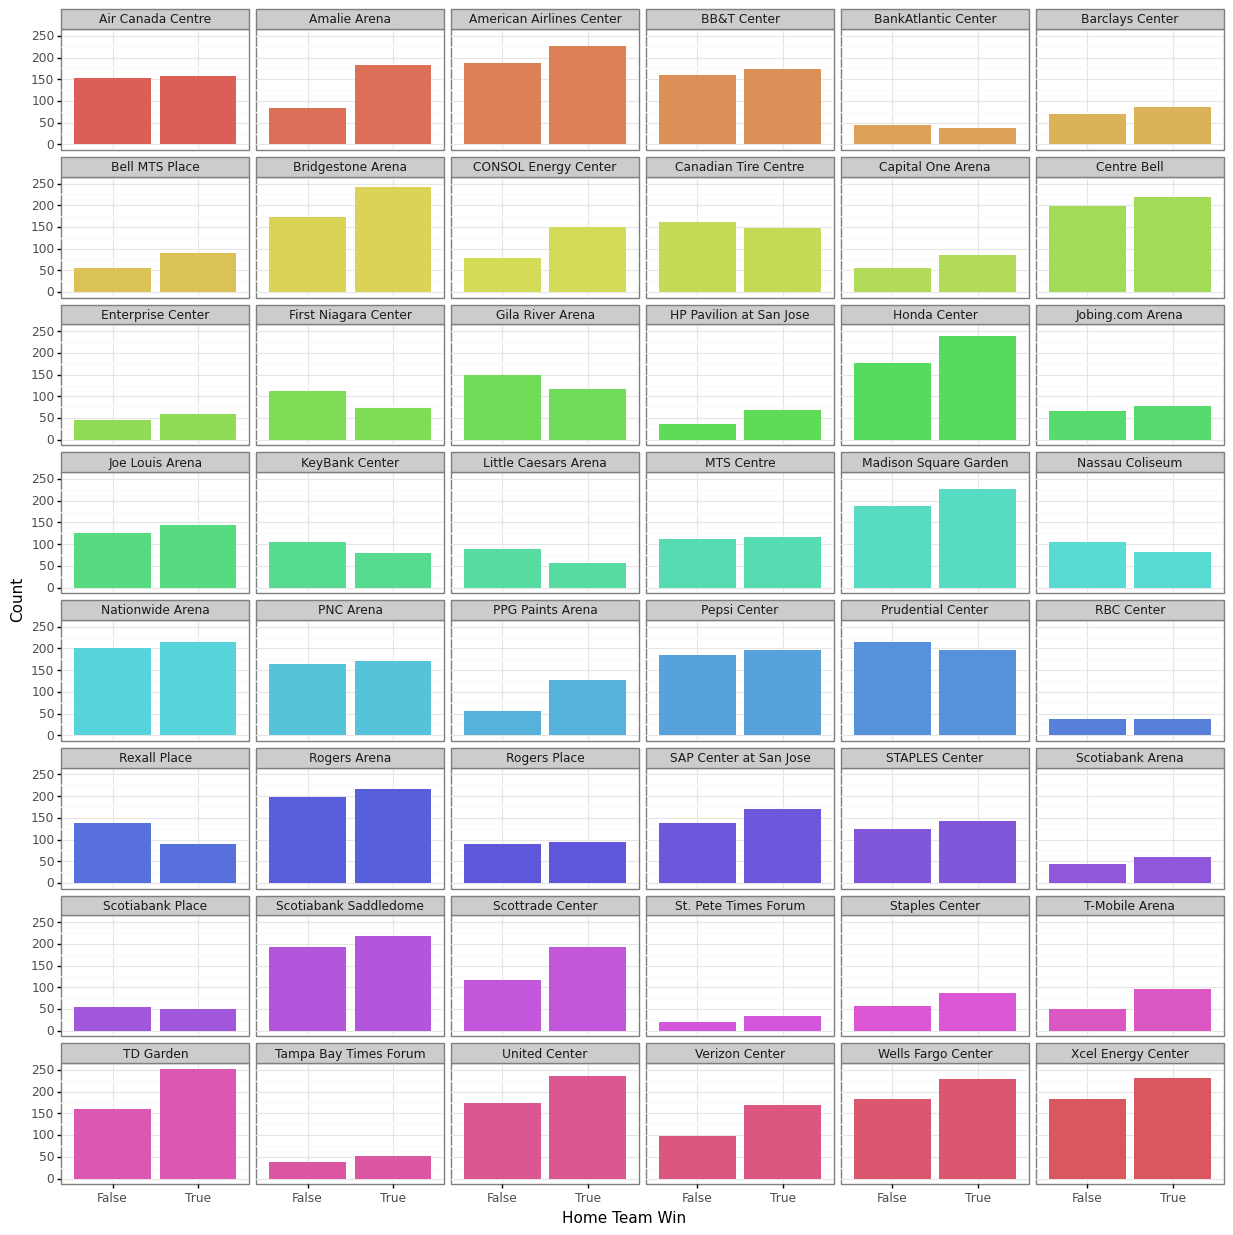

<ggplot: (345562486)>

In [13]:
plotnine.options.figure_size = (15, 15)

# number of games the home team has won at each venue thoughout the 2010-2021 season
(
ggplot(game_results[game_results['venue'].isin(common_venues)], aes(x = "homeTeamWin", fill = 'venue')) + 
    geom_bar() + 
    theme_bw() + 
    facet_wrap(" ~ venue", ncol = 6) +
    scale_fill_discrete(guide=False) +
    labs(x = "Home Team Win", y = "Count")
)

# Data Preprocessing

Here we will do the feature engineering and manipulation to get the player and team stat datasets into a form usuable for modeling. The desired modeling dataset will be the home team stats minus the away team stats. Therefore, positive numbers will signify the home team as higher stats up to that point in the season, and negative numbers will indicate that the away team has higher stats.

In [14]:
# adding win and losing streaks to the team stats
def win_lose(df):
    win_streak=0
    df["winStreak"] = 0
    lose_streak=0
    df["loseStreak"] = 0
    games_won=0
    games_lost = 0
    df["gamesWon"] = 0
    df["gamesLost"] = 0
    for index, row in df.iterrows():
        if (df.loc[index, "homeAway"] == "home" and df.loc[index, "homeTeamWin"]) or (df.loc[index, "homeAway"] == "away" and not df.loc[index, "homeTeamWin"]):
            win_streak+=1
            df.loc[index, "winStreak"] = win_streak
            lose_streak=0
            df.loc[index, "loseStreak"] = lose_streak
            games_won+=1
            df.loc[index, "gamesWon"] = games_won
            df.loc[index, "gamesLost"] = games_lost
        else:
            win_streak=0
            df.loc[index, "winStreak"] = win_streak
            lose_streak+=1
            df.loc[index, "loseStreak"] = lose_streak
            games_lost+=1
            df.loc[index, "gamesWon"] = games_won
            df.loc[index, "gamesLost"] = games_lost
    return(df)


team_stats_game['season'] = add_season(team_stats_game)
team_stats_game['gamesPlayed'] = 1
team_num_vars = team_stats_game.select_dtypes(include = ['float64', 'int64']).columns.to_list()

# creating cumulative totals for the 
cum_team_num_stats = team_stats_game \
    .groupby(by=['teamID', 'season'])[team_num_vars] \
    .cumsum()
# creating the full cumulative team stats dataframe
cum_team_stats = pd.concat([team_stats_game.drop(columns=team_num_vars), cum_team_num_stats], axis="columns")
team_percent_cols = cum_team_stats.filter(like="Percentage").columns.to_list()
cum_team_stats[team_percent_cols] = cum_team_stats[team_percent_cols].apply(lambda x: x/cum_team_stats["gamesPlayed"])

# adding win/lose and streak columns
cum_team_stats = cum_team_stats \
    .groupby(['teamID', "season"]) \
    .apply(win_lose)


In [15]:
cum_team_stats

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,season,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak,gamesWon,gamesLost
0,2010020001,home,True,Ron Wilson,10,Toronto Maple Leafs,2010/2011,3,6,24,0.000000,0.0,5.0,46.500000,22,6,16,27,1,1,0,1,0
1,2010020001,away,True,Jacques Martin,8,Montréal Canadiens,2010/2011,2,10,28,0.000000,0.0,3.0,53.500000,21,7,7,34,1,0,1,0,1
2,2010020002,home,False,Dan Bylsma,5,Pittsburgh Penguins,2010/2011,2,10,31,20.000000,1.0,5.0,60.700000,14,9,11,32,1,0,1,0,1
3,2010020002,away,False,Peter Laviolette,4,Philadelphia Flyers,2010/2011,3,12,27,25.000000,1.0,4.0,39.300000,16,1,9,34,1,1,0,1,0
4,2010020003,home,False,Todd Richards,30,Minnesota Wild,2010/2011,3,10,29,40.000000,2.0,5.0,61.200000,19,8,11,19,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25176,2020020866,away,True,Craig Berube,19,St. Louis Blues,2020/2021,167,456,1622,23.687500,36.0,155.0,53.346429,760,338,447,1257,56,0,3,27,29
25177,2020020867,home,False,Todd McLellan,26,Los Angeles Kings,2020/2021,142,395,1587,17.323214,32.0,169.0,50.728571,746,195,406,1065,56,0,2,21,35
25178,2020020867,away,False,Jared Bednar,21,Colorado Avalanche,2020/2021,197,499,1937,20.239286,47.0,207.0,51.691071,677,356,349,926,56,2,0,39,17
25179,2020020868,home,False,Bob Boughner,28,San Jose Sharks,2020/2021,146,514,1682,12.766071,22.0,156.0,48.337500,812,426,387,1250,56,0,2,21,35


In [16]:
pd.crosstab(index=cum_team_stats['winStreak'], columns=cum_team_stats['homeTeamWin'])

homeTeamWin,False,True
winStreak,,
0,5755,6835
1,2869,3374
2,1430,1699
3,695,850
4,355,422
5,190,222
6,107,117
7,48,68
8,20,40


Here, the same process will be used to create a cumulative player stats dataset for each season.

In [17]:
player_stats["season"] = add_season(player_stats)
player_stats["gamesPlayed"] = 1
player_stats[['faceoffTaken', "faceOffWins", "faceOffPct"]] = player_stats[['faceoffTaken', "faceOffWins", "faceOffPct"]].fillna(value=0)

# adding a point streak column for players
def point_streak(df):
    point_streak=0
    df["pointStreak"] = 0
    for index, row in df.iterrows():
        if (df.loc[index, "assists"] > 0 or df.loc[index, 'goals'] > 0):
            point_streak+=1
            df.loc[index, "pointStreak"] = point_streak
        else:
            point_streak=0
            df.loc[index, "pointStreak"] = point_streak
    return(df)

# function to clean the time on ice from minutes:seconds format to a decimal
def clean_toi(x):
    time = x.str.split(":")
    minutes = time.str.get(0)
    seconds = time.str.get(1).astype(int)*100/60
    return minutes + "." + seconds.round().astype(int).astype(str)

time_on_ice_cols = ['timeOnIce', 'powerPlayTimeOnIce', 'evenTimeOnIce', 'shortHandedTimeOnIce']
# had to change the clean_toi function a few times because the list wasn't working right...
player_stats[time_on_ice_cols] = player_stats[time_on_ice_cols].apply(clean_toi).astype(float)

player_num_vars = player_stats.select_dtypes(include = ['float64', 'int64']).columns.to_list()

# adding player point streak column
player_stats = player_stats \
    .groupby(['playerID', 'season']) \
    .apply(point_streak)

# creating cumulative totals for the 
cum_player_num_stats = player_stats \
    .groupby(by=['playerID', 'season'])[player_num_vars] \
    .cumsum()

# creating the full cumulative team stats dataframe
cum_player_stats = pd.concat([player_stats.drop(columns=player_num_vars), cum_player_num_stats], 
                             axis="columns")

# turning time on ice stats into season averages
cum_player_stats[time_on_ice_cols] = cum_player_stats[time_on_ice_cols].apply(lambda x: x/cum_player_stats['gamesPlayed'])

# function to determine if a player is on a hot/point streak
def hot_players(x, thresh):
    return x >= thresh
cum_player_stats["hotPlayer"] = hot_players(cum_player_stats.pointStreak, 2).astype(int)
cum_player_stats["faceOffPct"] = cum_player_stats["faceOffWins"] / cum_player_stats['faceoffTaken']
cum_player_stats["faceOffPct"] = cum_player_stats["faceOffPct"].fillna(value=0)

In [18]:
# cum_player_stats["faceOffPct"] = cum_player_stats["faceOffWins"] / cum_player_stats['faceoffTaken']
# cum_player_stats["faceOffPct"] = cum_player_stats["faceOffPct"].fillna(value=0)
cum_player_stats


,gameID,playerID,fullName,position,homeAway,teamID,teamName,season,pointStreak,timeOnIce,assists,goals,shots,...,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,powerPlayTimeOnIce,shortHandedTimeOnIce,faceOffPct,gamesPlayed,hotPlayer
0,2010020001,8468778,Colton Orr,R,home,10,Toronto Maple Leafs,2010/2011,0,3.320000,0,0,0,...,0,0,0,0,0,0,1,3.320000,0.000000,0.000000,0.000000,1,0
1,2010020001,8470602,Dion Phaneuf,D,home,10,Toronto Maple Leafs,2010/2011,1,23.750000,1,0,2,...,0,0,1,0,0,3,1,15.180000,6.780000,1.780000,0.000000,1,0
2,2010020001,8465200,Tomas Kaberle,D,home,10,Toronto Maple Leafs,2010/2011,0,23.920000,0,0,2,...,0,0,0,0,0,2,0,16.270000,7.650000,0.000000,0.000000,1,0
3,2010020001,8467400,Francois Beauchemin,D,home,10,Toronto Maple Leafs,2010/2011,0,22.350000,0,0,1,...,0,1,2,0,0,3,0,15.700000,3.420000,3.230000,0.000000,1,0
4,2010020001,8474125,Carl Gunnarsson,D,home,10,Toronto Maple Leafs,2010/2011,0,17.550000,0,0,1,...,0,1,3,0,0,2,1,13.320000,1.470000,2.770000,0.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453232,2020020868,8478047,Michael Bunting,L,away,53,Arizona Coyotes,2020/2021,0,16.752381,3,10,38,...,12,9,5,0,0,1,-1,14.839524,1.917619,0.042857,0.583333,21,0
453233,2020020868,8477392,Hudson Fasching,R,away,53,Arizona Coyotes,2020/2021,0,9.464000,0,0,7,...,0,0,1,0,0,1,-3,9.328000,0.000000,0.136000,0.000000,5,0
453234,2020020868,8480890,Jan Jenik,R,away,53,Arizona Coyotes,2020/2021,2,12.215000,0,2,3,...,23,1,0,0,0,0,3,12.215000,0.000000,0.000000,0.521739,2,1
453235,2020020868,8475171,Oliver Ekman-Larsson,D,away,53,Arizona Coyotes,2020/2021,3,21.005000,21,3,83,...,0,12,25,0,0,26,-17,16.874565,2.402826,1.754783,0.000000,46,1


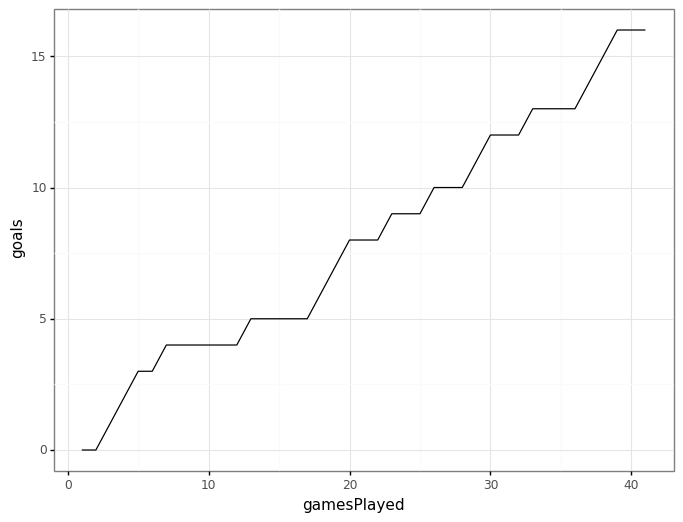

<ggplot: (352840039)>

In [19]:
plotnine.options.figure_size = (8, 6)

(
ggplot(cum_player_stats.query("fullName == 'Sidney Crosby' & season == '2019/2020'"), aes(x = "gamesPlayed", y = "goals")) + 
    geom_line() + 
    theme_bw()
)

Lastly we'll do the same cumulative stats for goalies.


In [20]:
goalie_stats.columns

Index(['gameID', 'playerID', 'fullName', 'position', 'homeAway', 'teamID',
       'teamName', 'timeOnIce', 'assists', 'goals', 'pim', 'shots', 'saves',
       'powerPlaySaves', 'shortHandedSaves', 'evenSaves',
       'shortHandedShotsAgainst', 'evenShotsAgainst', 'powerPlayShotsAgainst',
       'decision', 'savePercentage', 'powerPlaySavePercentage',
       'shortHandedSavePercentage', 'evenStrengthSavePercentage'],
      dtype='object')

In [21]:
goalie_stats["season"] = add_season(goalie_stats)
goalie_stats["gamesPlayed"] = 1
goalie_num_vars = goalie_stats.select_dtypes(include = ['float64', 'int64']).columns.to_list()

# creating cumulative totals for the 
cum_goalie_num_stats = goalie_stats \
    .groupby(by=['playerID', 'season'])[goalie_num_vars] \
    .cumsum()
# creating the full cumulative team stats dataframe
cum_goalie_stats = pd.concat([goalie_stats.drop(columns=goalie_num_vars), cum_goalie_num_stats], axis="columns")

save_percentages = ["savePercentage", "powerPlaySavePercentage", "shortHandedSavePercentage", "evenStrengthSavePercentage"]

cum_goalie_stats[save_percentages] = cum_goalie_stats[save_percentages].fillna(value=0).apply(lambda x: x/cum_goalie_stats["gamesPlayed"])

In [22]:
cum_goalie_stats

,gameID,playerID,fullName,position,homeAway,teamID,teamName,timeOnIce,decision,season,assists,goals,pim,shots,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,savePercentage,powerPlaySavePercentage,shortHandedSavePercentage,evenStrengthSavePercentage,gamesPlayed
0,2010020001,8462044,Jean-Sebastien Giguere,G,home,10,Toronto Maple Leafs,58:49,W,2010/2011,0,0,0,28,26,3,2,21,2,23,3,92.857143,100.000000,100.000000,91.304348,1
1,2010020001,8471679,Carey Price,G,away,8,Montréal Canadiens,58:59,L,2010/2011,0,0,0,24,21,2,0,19,0,22,2,87.500000,100.000000,0.000000,86.363636,1
2,2010020002,8470594,Marc-Andre Fleury,G,home,5,Pittsburgh Penguins,58:47,L,2010/2011,0,0,0,27,24,3,1,20,2,21,4,88.888889,75.000000,50.000000,95.238095,1
3,2010020002,8475683,Sergei Bobrovsky,G,away,4,Philadelphia Flyers,60:00,W,2010/2011,0,0,0,31,29,3,1,25,1,26,4,93.548387,75.000000,100.000000,96.153846,1
4,2010020003,8473404,Niklas Backstrom,G,home,30,Minnesota Wild,58:45,L,2010/2011,0,0,0,31,27,1,1,25,1,27,3,87.096774,33.333333,100.000000,92.592593,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27099,2020020866,8478024,Ville Husso,G,away,19,St. Louis Blues,58:57,L,2020/2021,0,0,4,460,411,65,9,337,10,374,76,88.351681,76.587302,89.192179,32.352941,17
27100,2020020867,8477361,Calvin Petersen,G,home,26,Los Angeles Kings,58:03,L,2020/2021,1,0,0,1095,998,154,34,810,37,885,173,90.853910,78.937642,91.510090,0.000000,35
27101,2020020867,8477992,Jonas Johansson,G,away,21,Colorado Avalanche,59:53,W,2020/2021,0,0,0,380,341,52,4,285,4,318,58,83.860602,71.616162,83.707053,0.000000,15
27102,2020020868,8482246,Alexei Melnichuk,G,home,28,San Jose Sharks,61:24,L,2020/2021,0,0,0,81,70,7,1,62,1,72,8,90.246212,33.333333,90.150150,33.333333,3


In [23]:
def goalie_consec_games(df):
    consec_games = 0
    df["goalieConsecutiveGames"] = 0
    for index, row in df.iterrows():
        if (df.loc[index, "playerID"] == df.shift(1).loc[index, "playerID"]):
            consec_games+=1
            df.loc[index, "goalieConsecutiveGames"] = consec_games
        else:
            consec_games=0
            df.loc[index, "goalieConsecutiveGames"] = consec_games
    
    return(df)

cum_goalie_stats = cum_goalie_stats \
    .groupby(['teamID', 'season']) \
    .apply(goalie_consec_games)
# goalie_consec_games(cum_goalie_stats.query("teamID == '10' & season == '2011/2012'"))

# cum_goalie_stats.query("teamID == '10' & season == '2011/2012'").shift(1)#.iloc[0].shift(1)

In [24]:
cum_goalie_stats

,gameID,playerID,fullName,position,homeAway,teamID,teamName,timeOnIce,decision,season,assists,goals,pim,shots,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,savePercentage,powerPlaySavePercentage,shortHandedSavePercentage,evenStrengthSavePercentage,gamesPlayed,goalieConsecutiveGames
0,2010020001,8462044,Jean-Sebastien Giguere,G,home,10,Toronto Maple Leafs,58:49,W,2010/2011,0,0,0,28,26,3,2,21,2,23,3,92.857143,100.000000,100.000000,91.304348,1,0
1,2010020001,8471679,Carey Price,G,away,8,Montréal Canadiens,58:59,L,2010/2011,0,0,0,24,21,2,0,19,0,22,2,87.500000,100.000000,0.000000,86.363636,1,0
2,2010020002,8470594,Marc-Andre Fleury,G,home,5,Pittsburgh Penguins,58:47,L,2010/2011,0,0,0,27,24,3,1,20,2,21,4,88.888889,75.000000,50.000000,95.238095,1,0
3,2010020002,8475683,Sergei Bobrovsky,G,away,4,Philadelphia Flyers,60:00,W,2010/2011,0,0,0,31,29,3,1,25,1,26,4,93.548387,75.000000,100.000000,96.153846,1,0
4,2010020003,8473404,Niklas Backstrom,G,home,30,Minnesota Wild,58:45,L,2010/2011,0,0,0,31,27,1,1,25,1,27,3,87.096774,33.333333,100.000000,92.592593,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27099,2020020866,8478024,Ville Husso,G,away,19,St. Louis Blues,58:57,L,2020/2021,0,0,4,460,411,65,9,337,10,374,76,88.351681,76.587302,89.192179,32.352941,17,0
27100,2020020867,8477361,Calvin Petersen,G,home,26,Los Angeles Kings,58:03,L,2020/2021,1,0,0,1095,998,154,34,810,37,885,173,90.853910,78.937642,91.510090,0.000000,35,3
27101,2020020867,8477992,Jonas Johansson,G,away,21,Colorado Avalanche,59:53,W,2020/2021,0,0,0,380,341,52,4,285,4,318,58,83.860602,71.616162,83.707053,0.000000,15,0
27102,2020020868,8482246,Alexei Melnichuk,G,home,28,San Jose Sharks,61:24,L,2020/2021,0,0,0,81,70,7,1,62,1,72,8,90.246212,33.333333,90.150150,33.333333,3,0


In [25]:
cum_team_stats

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,season,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak,gamesWon,gamesLost
0,2010020001,home,True,Ron Wilson,10,Toronto Maple Leafs,2010/2011,3,6,24,0.000000,0.0,5.0,46.500000,22,6,16,27,1,1,0,1,0
1,2010020001,away,True,Jacques Martin,8,Montréal Canadiens,2010/2011,2,10,28,0.000000,0.0,3.0,53.500000,21,7,7,34,1,0,1,0,1
2,2010020002,home,False,Dan Bylsma,5,Pittsburgh Penguins,2010/2011,2,10,31,20.000000,1.0,5.0,60.700000,14,9,11,32,1,0,1,0,1
3,2010020002,away,False,Peter Laviolette,4,Philadelphia Flyers,2010/2011,3,12,27,25.000000,1.0,4.0,39.300000,16,1,9,34,1,1,0,1,0
4,2010020003,home,False,Todd Richards,30,Minnesota Wild,2010/2011,3,10,29,40.000000,2.0,5.0,61.200000,19,8,11,19,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25176,2020020866,away,True,Craig Berube,19,St. Louis Blues,2020/2021,167,456,1622,23.687500,36.0,155.0,53.346429,760,338,447,1257,56,0,3,27,29
25177,2020020867,home,False,Todd McLellan,26,Los Angeles Kings,2020/2021,142,395,1587,17.323214,32.0,169.0,50.728571,746,195,406,1065,56,0,2,21,35
25178,2020020867,away,False,Jared Bednar,21,Colorado Avalanche,2020/2021,197,499,1937,20.239286,47.0,207.0,51.691071,677,356,349,926,56,2,0,39,17
25179,2020020868,home,False,Bob Boughner,28,San Jose Sharks,2020/2021,146,514,1682,12.766071,22.0,156.0,48.337500,812,426,387,1250,56,0,2,21,35


In [26]:
# counting the number of hot players each team has after each game
game_hot_players = cum_player_stats \
    .groupby(["gameID", "teamID", "season"])['hotPlayer'] \
    .sum() \
    .reset_index()

# merging these in
cum_team_stats = pd.merge(cum_team_stats, game_hot_players, on=["gameID", "teamID", "season"])

In [27]:
cum_team_stats

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,season,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak,gamesWon,gamesLost,hotPlayer
0,2010020001,home,True,Ron Wilson,10,Toronto Maple Leafs,2010/2011,3,6,24,0.000000,0.0,5.0,46.500000,22,6,16,27,1,1,0,1,0,0
1,2010020001,away,True,Jacques Martin,8,Montréal Canadiens,2010/2011,2,10,28,0.000000,0.0,3.0,53.500000,21,7,7,34,1,0,1,0,1,0
2,2010020002,home,False,Dan Bylsma,5,Pittsburgh Penguins,2010/2011,2,10,31,20.000000,1.0,5.0,60.700000,14,9,11,32,1,0,1,0,1,0
3,2010020002,away,False,Peter Laviolette,4,Philadelphia Flyers,2010/2011,3,12,27,25.000000,1.0,4.0,39.300000,16,1,9,34,1,1,0,1,0,0
4,2010020003,home,False,Todd Richards,30,Minnesota Wild,2010/2011,3,10,29,40.000000,2.0,5.0,61.200000,19,8,11,19,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25176,2020020866,away,True,Craig Berube,19,St. Louis Blues,2020/2021,167,456,1622,23.687500,36.0,155.0,53.346429,760,338,447,1257,56,0,3,27,29,0
25177,2020020867,home,False,Todd McLellan,26,Los Angeles Kings,2020/2021,142,395,1587,17.323214,32.0,169.0,50.728571,746,195,406,1065,56,0,2,21,35,3
25178,2020020867,away,False,Jared Bednar,21,Colorado Avalanche,2020/2021,197,499,1937,20.239286,47.0,207.0,51.691071,677,356,349,926,56,2,0,39,17,4
25179,2020020868,home,False,Bob Boughner,28,San Jose Sharks,2020/2021,146,514,1682,12.766071,22.0,156.0,48.337500,812,426,387,1250,56,0,2,21,35,2


In [28]:
cum_team_num_vars = cum_team_stats.select_dtypes(include = ['float64', 'int64']).columns.to_list()

shifted_team_stats = cum_team_stats.groupby(['teamID', "season"])[cum_team_num_vars].shift(1)
short_team_stats = cum_team_stats.drop(columns=cum_team_num_vars)#.groupby(['teamID', "season"])[cum_team_num_vars].shift(1)

proper_team_stats = pd.concat([short_team_stats, shifted_team_stats], axis="columns").dropna()

# cum_team_stats.groupby(['teamID', "season"]).shift(1).dropna()

In [29]:
proper_team_stats.head()

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,season,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak,gamesWon,gamesLost,hotPlayer
14,2010020008,home,True,Paul Maurice,12,Carolina Hurricanes,2010/2011,4.0,10.0,31.0,40.0,2.0,5.0,38.8,19.0,3.0,11.0,14.0,1.0,1.0,0.0,1.0,0.0,0.0
15,2010020008,away,True,Todd Richards,30,Minnesota Wild,2010/2011,3.0,10.0,29.0,40.0,2.0,5.0,61.2,19.0,8.0,11.0,19.0,1.0,0.0,1.0,0.0,1.0,0.0
24,2010020013,home,False,Lindy Ruff,7,Buffalo Sabres,2010/2011,2.0,12.0,36.0,20.0,1.0,5.0,43.4,20.0,5.0,8.0,22.0,1.0,1.0,0.0,1.0,0.0,0.0
26,2010020014,home,True,Ron Wilson,10,Toronto Maple Leafs,2010/2011,3.0,6.0,24.0,0.0,0.0,5.0,46.5,22.0,6.0,16.0,27.0,1.0,1.0,0.0,1.0,0.0,0.0
27,2010020014,away,True,Cory Clouston,9,Ottawa Senators,2010/2011,1.0,12.0,26.0,0.0,0.0,5.0,56.6,7.0,16.0,18.0,26.0,1.0,0.0,1.0,0.0,1.0,0.0


In [30]:
home_team = proper_team_stats.query("homeAway == 'home'").sort_values('gameID').reset_index().drop(columns="index")

In [31]:
away_team = proper_team_stats.query("homeAway == 'away'").sort_values('gameID').reset_index().drop(columns="index")

In [32]:
full_gameID_stats = pd.merge(home_team.gameID, away_team.gameID, how="inner")
full_gameID_stats['gameID'] = full_gameID_stats.gameID.astype(str)
home_team_clean = pd.merge(home_team, full_gameID_stats, how="inner", on="gameID")
away_team_clean = pd.merge(away_team, full_gameID_stats, how="inner", on="gameID")

prior_game_stats = pd.concat([full_gameID_stats, home_team_clean[cum_team_num_vars].subtract(away_team_clean[cum_team_num_vars])], axis="columns")

In [33]:
game_results.head()

,gameID,season,dateTime,gameType,homeTeamID,homeTeamName,awayTeamID,awayTeamName,homeGoals,awayGoals,homeTeamWin,venue
0,2010020001,2010/2011,2010-10-07,R,10,Toronto Maple Leafs,8,Montréal Canadiens,3,2,True,Air Canada Centre
1,2010020002,2010/2011,2010-10-07,R,5,Pittsburgh Penguins,4,Philadelphia Flyers,2,3,False,CONSOL Energy Center
2,2010020003,2010/2011,2010-10-07,R,30,Minnesota Wild,12,Carolina Hurricanes,3,4,False,Hartwall Areena
3,2010020004,2010/2011,2010-10-08,R,21,Colorado Avalanche,16,Chicago Blackhawks,4,3,True,Pepsi Center
4,2010020005,2010/2011,2010-10-08,R,22,Edmonton Oilers,20,Calgary Flames,4,0,True,Rexall Place


In [34]:
prediction_df = pd.merge(game_results.filter(items=['gameID', 'season', "homeTeamWin", "venue"]), prior_game_stats, how = "inner", on="gameID")


In [35]:
prediction_df['homeTeamWin'] = prediction_df.homeTeamWin.astype(int)
prediction_df = prediction_df.drop(columns = ["gamesLost", "gamesPlayed"]).copy()

In [36]:
prediction_df

,gameID,season,homeTeamWin,venue,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,winStreak,loseStreak,gamesWon,hotPlayer
0,2010020008,2010/2011,1,Hartwall Areena,1.0,0.0,2.0,0.000000,0.0,0.0,-22.400000,0.0,-5.0,0.0,-5.0,1.0,-1.0,1.0,0.0
1,2010020014,2010/2011,1,Air Canada Centre,2.0,-6.0,-2.0,0.000000,0.0,0.0,-10.100000,15.0,-10.0,-2.0,1.0,1.0,-1.0,1.0,0.0
2,2010020016,2010/2011,0,CONSOL Energy Center,0.0,0.0,3.0,20.000000,1.0,2.0,7.200000,-7.0,2.0,4.0,-2.0,0.0,0.0,0.0,0.0
3,2010020017,2010/2011,1,Verizon Center,-1.0,4.0,1.0,-100.000000,-1.0,2.0,7.900000,4.0,11.0,0.0,9.0,0.0,0.0,0.0,0.0
4,2010020021,2010/2011,0,United Center,-1.0,-20.0,-5.0,28.600000,2.0,1.0,-18.100000,2.0,6.0,-5.0,-2.0,-1.0,1.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12391,2020020864,2020/2021,1,Rogers Arena,-9.0,102.0,-44.0,-0.503636,-5.0,-20.0,2.587273,126.0,-21.0,-157.0,-102.0,-1.0,6.0,-4.0,1.0
12392,2020020865,2020/2021,1,Xcel Energy Center,55.0,4.0,82.0,7.147273,17.0,39.0,-4.500000,82.0,12.0,-89.0,-322.0,1.0,-1.0,17.0,1.0
12393,2020020866,2020/2021,1,T-Mobile Arena,20.0,-46.0,199.0,-8.072727,-6.0,18.0,-3.605455,84.0,63.0,-105.0,-22.0,2.0,-2.0,12.0,4.0
12394,2020020867,2020/2021,0,STAPLES Center,-54.0,-106.0,-338.0,-2.363636,-14.0,-37.0,-1.263636,70.0,-157.0,59.0,146.0,-1.0,1.0,-17.0,0.0


In [37]:
prediction_df.homeTeamWin.value_counts()

1    6735
0    5661
Name: homeTeamWin, dtype: int64

# Some EDA on the newly created dataset

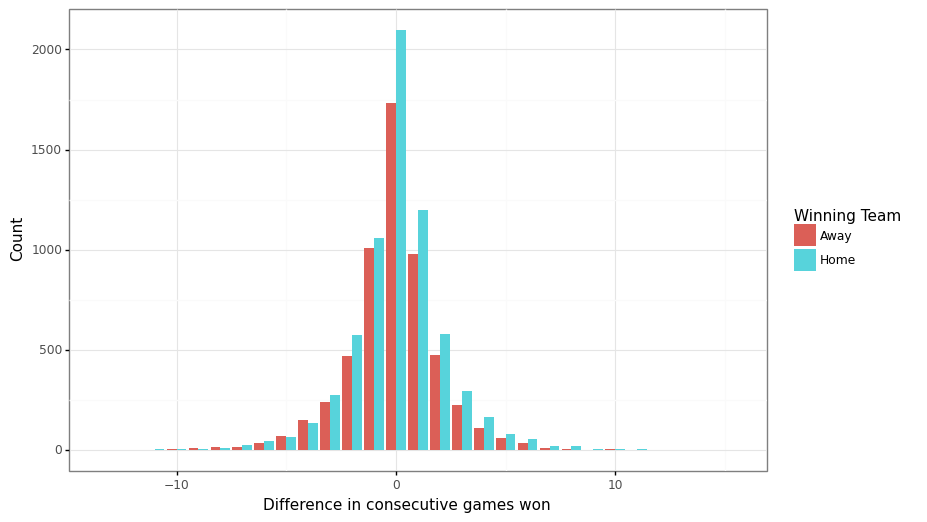

<ggplot: (352802892)>

In [38]:
eda_df = prediction_df.copy()
eda_df["homeTeamWin"] = eda_df["homeTeamWin"].map({0:"Away", 1:"Home"})

plotnine.options.figure_size = (9, 6)
(
ggplot(eda_df, aes(x="winStreak", fill='homeTeamWin')) + 
    geom_bar(position='dodge') + 
    theme_bw() + 
    labs(x="Difference in consecutive games won", y="Count", fill="Winning Team") #+
#     facet_wrap(" ~ homeTeamWin")
)

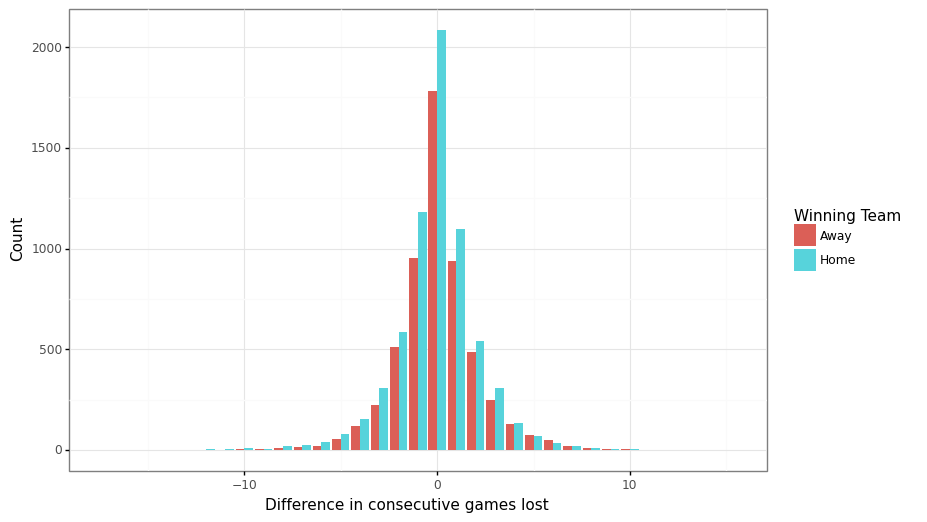

<ggplot: (352377730)>

In [39]:
plotnine.options.figure_size = (9, 6)
(
ggplot(eda_df, aes(x="loseStreak", fill='homeTeamWin')) + 
    geom_bar(position='dodge') + 
    theme_bw() + 
    labs(x="Difference in consecutive games lost", y="Count", fill="Winning Team") #+
#     facet_wrap(" ~ homeTeamWin")
)

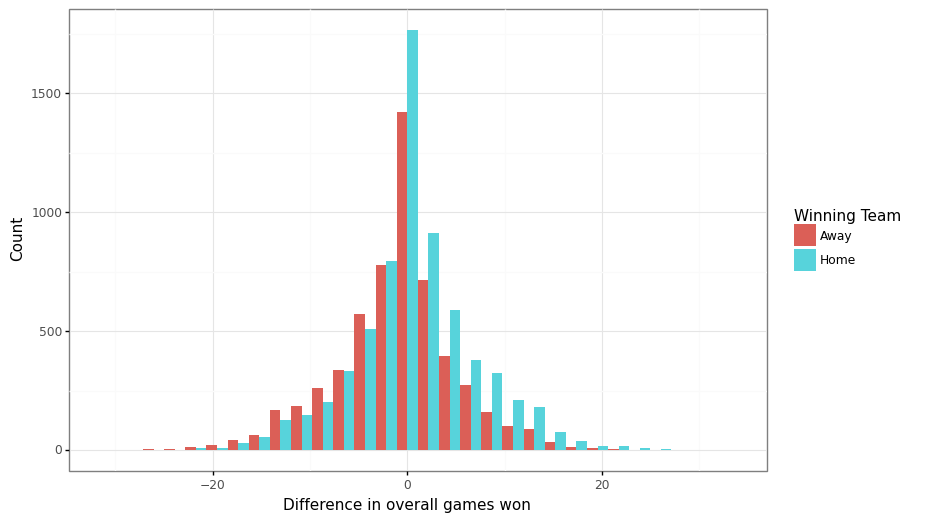

<ggplot: (352885694)>

In [40]:
plotnine.options.figure_size = (9, 6)
(
ggplot(eda_df, aes(x="gamesWon", fill='homeTeamWin')) + 
    geom_histogram(bins=30, position="dodge") + 
    theme_bw() + 
    labs(x="Difference in overall games won", y="Count", fill="Winning Team") #+
#     facet_wrap(" ~ homeTeamWin")
)

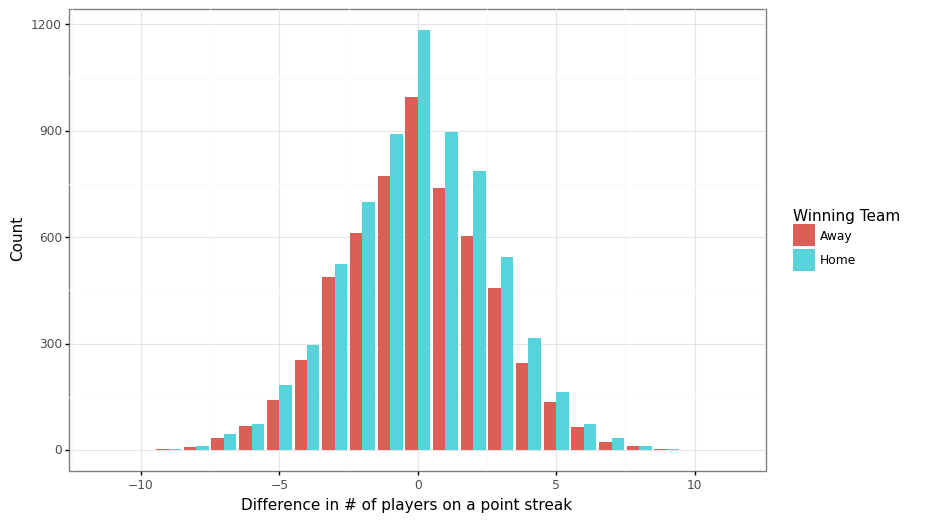

<ggplot: (280326111)>

In [41]:
plotnine.options.figure_size = (9, 6)
(
ggplot(eda_df, aes(x="hotPlayer", fill='homeTeamWin')) + 
    geom_bar(position='dodge') + 
    theme_bw() + 
    labs(x="Difference in # of players on a point streak", y="Count", fill="Winning Team") #+
#     facet_wrap(" ~ homeTeamWin")
)

/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_density : Removed 6 rows containing non-finite values.


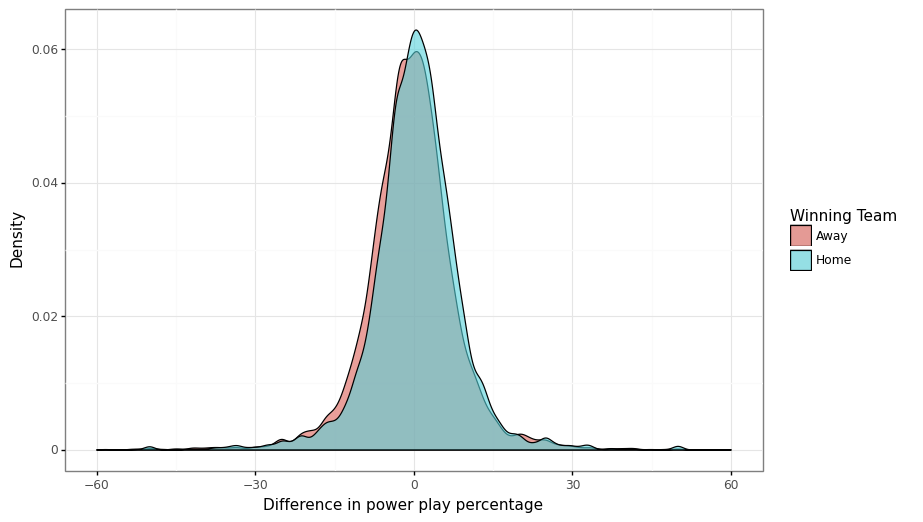

<ggplot: (352212559)>

In [42]:
plotnine.options.figure_size = (9, 6)
(
ggplot(eda_df, aes(x="powerPlayPercentage", fill='homeTeamWin')) + 
    geom_density(alpha = .6) + #histogram(position='dodge', bins=40) + 
    theme_bw() + 
    scale_x_continuous(limits = (-60, 60)) +
    labs(x="Difference in power play percentage", y="Density", fill="Winning Team") #+
#     facet_wrap(" ~ homeTeamWin")
)

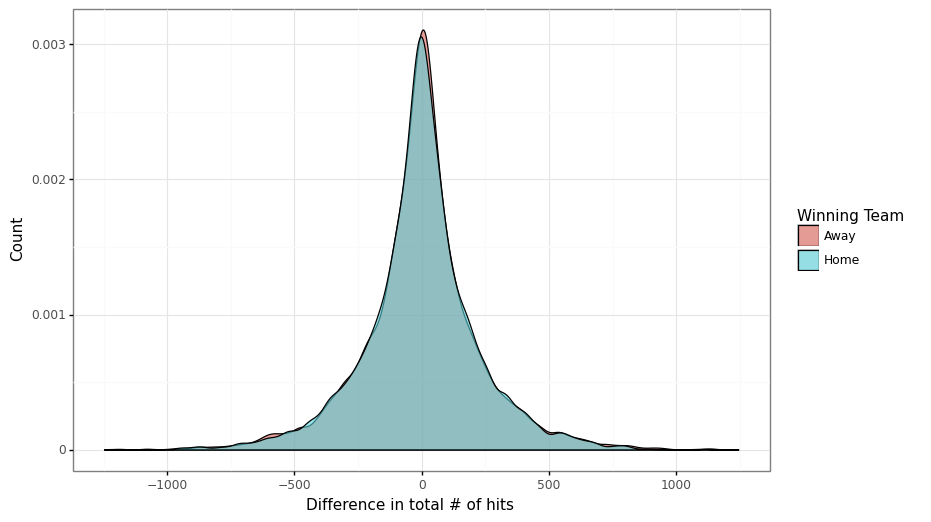

<ggplot: (352969223)>

In [43]:
plotnine.options.figure_size = (9, 6)
(
ggplot(eda_df, aes(x="hits", fill='homeTeamWin')) + 
    geom_density(alpha = .6) + #histogram(position='dodge', bins=40) + 
    theme_bw() + 
    labs(x="Difference in total # of hits", y="Count", fill="Winning Team") #+
#     facet_wrap(" ~ homeTeamWin")
)

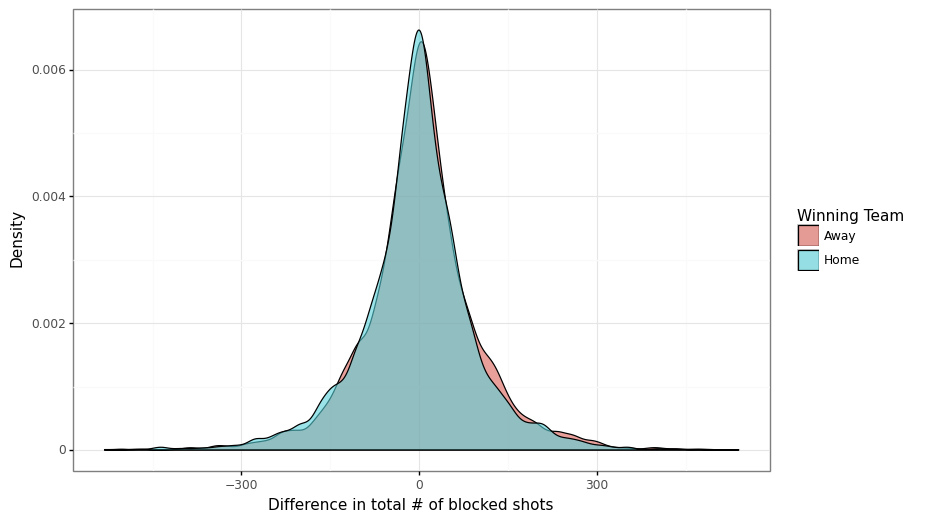

<ggplot: (353033870)>

In [44]:
plotnine.options.figure_size = (9, 6)
(
ggplot(eda_df, aes(x="blocked", fill='homeTeamWin')) + 
    geom_density(alpha = .6) + #histogram(position='dodge', bins=40) + 
    theme_bw() + 
    labs(x="Difference in total # of blocked shots", y="Density", fill="Winning Team") #+
#     facet_wrap(" ~ homeTeamWin")
)

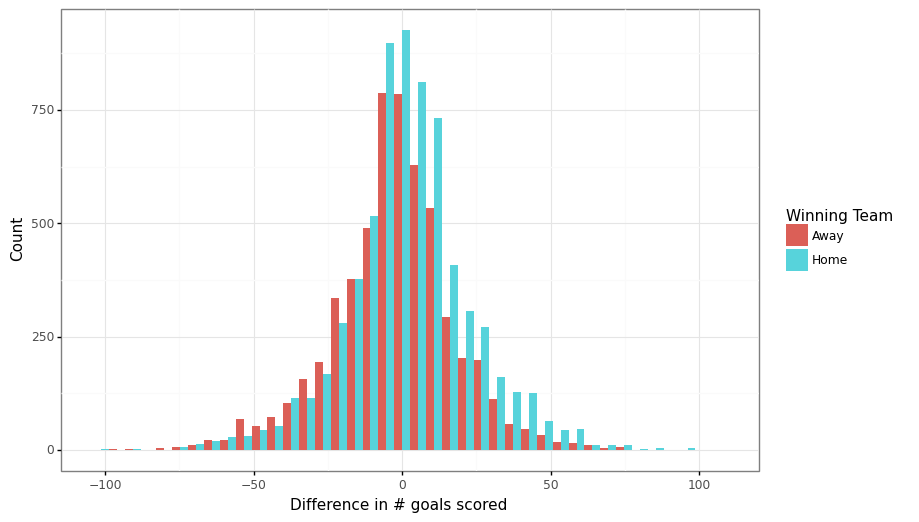

<ggplot: (352170563)>

In [45]:
plotnine.options.figure_size = (9, 6)
(
ggplot(eda_df, aes(x="goals", fill='homeTeamWin')) + 
    geom_histogram(position='dodge', bins=40) + 
    theme_bw() + 
    labs(x="Difference in # goals scored", y="Count", fill="Winning Team") #+
#     facet_wrap(" ~ homeTeamWin")
)

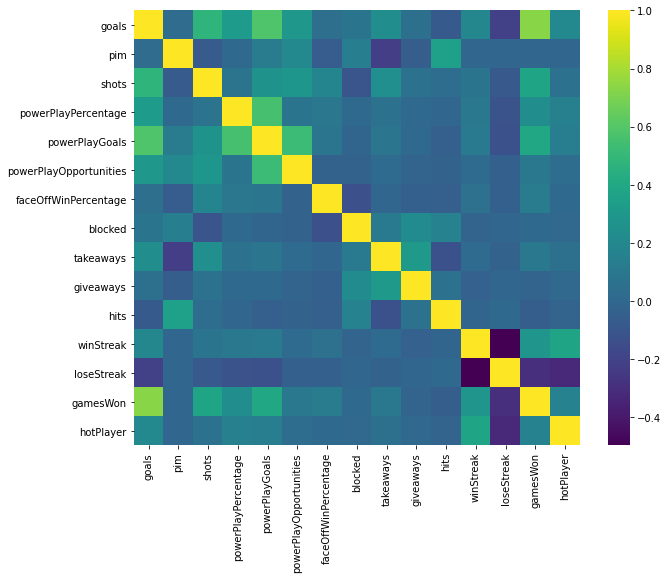

In [46]:
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(eda_df.corr(), ax = ax, cmap = "viridis");

# Predictions

This method will train on the data from 2010-2019 seasons and test on the 2020/2021 season. Very much just a test to see where we're at and get a baseline from a very basic, untuned Logistic Regression model.

In [47]:
X_train, X_test = prediction_df.query('season != "2020/2021"').drop(columns=["gameID", "season", "homeTeamWin", "venue"]), \
                  prediction_df.query('season == "2020/2021"').drop(columns=["gameID", "season", "homeTeamWin", "venue"])

y_train, y_test = prediction_df.query('season != "2020/2021"')['homeTeamWin'], \
                  prediction_df.query('season == "2020/2021"')['homeTeamWin']

X_train.shape
y_train.shape
X_test.shape
y_test.shape

(11544, 15)

(11544,)

(852, 15)

(852,)

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

log_reg = LogisticRegression(max_iter=1e4)

log_reg.fit(X_train, y_train)

train_preds = log_reg.predict(X_train)
test_preds = log_reg.predict(X_test)

pd.crosstab(y_train, train_preds)
pd.crosstab(y_test, test_preds)

accuracy_score(y_train, train_preds)
accuracy_score(y_test, test_preds)

y_test.value_counts()/len(y_test)

print(classification_report(y_test, test_preds))

LogisticRegression(max_iter=10000.0)

col_0,0,1
homeTeamWin,,
0,1450,3814
1,1164,5116


col_0,0,1
homeTeamWin,,
0,129,268
1,94,361


0.5687803187803188

0.5751173708920188

1    0.534038
0    0.465962
Name: homeTeamWin, dtype: float64

              precision    recall  f1-score   support

           0       0.58      0.32      0.42       397
           1       0.57      0.79      0.67       455

    accuracy                           0.58       852
   macro avg       0.58      0.56      0.54       852
weighted avg       0.58      0.58      0.55       852



In [49]:
for var, coef in zip(X_train.columns.values, log_reg.coef_[0]):
    print(var, ": ", coef, sep='')

goals: 0.0009688636069023931
pim: 0.0003447843593469456
shots: 0.0004948855895986191
powerPlayPercentage: 0.003267140531264277
powerPlayGoals: 0.004963465952381389
powerPlayOpportunities: -0.0021222792570417433
faceOffWinPercentage: 0.011426187292658676
blocked: -0.0006295284666577169
takeaways: -4.0175039957851603e-05
giveaways: -8.893507975921464e-05
hits: -2.017912883459541e-05
winStreak: 0.008176034198058757
loseStreak: 0.004294120323522702
gamesWon: 0.03128070907958913
hotPlayer: -0.00997204775852328


So right above here can be considered a base model, training on the 2010-2019 season data and testing on the 2019/2020 games. Not great accuracy, but that is to be expected. Theoretically it should be fine to make normal train/test sets since we want the model to learn how to predict all games. In a real scenario, we would train and validate on all data up to a season, but we can also experiment this way as well. This will give a few different approaches to modeling game data.

Other models will be included in the final training/predicting as well. This will setup a couple different approaches. Could also train/validate a model on all data before a certain season and then test predictions on the next season. An example would be what was already done, but continue to do for all other seasons in the span we collected data for. Theoretically, more data being available for training should help in prediction accuracies as we get closer to current seasons, but given the nature of hockey games, there might not be any benefit which would also be interesting as well. There is the theoretical limit of game results being able to be predicted only ~62% of the time. I'm hopeful to at least get close to this number using many different models and a model ensemble. If accuracies don't change, then better features might be needed which will have to happen later. 

I should also use models that can output probabilities as well since that would be the interesting thing to see in an app: what's the probability team X will beat team Y in this game given the current status of the season. Accuracy will be used as the metric because it will only really matter if the prediction is wrong. False positives or negatives carry equal weight in that we "lost the bet" in a sports gambling situation.

The aspect of "puck luck" has to be kept in mind because of how much affect a single lucky play can have on the outcome of a game. Predicting on a high level like this won't capture that obviously, and I believe that low level prediction model that predicts during games would benefit from a reinforcement learning approach. 

Could play around with a random multiplier to win probabilites and use that in a simulation style as well.

# Modeling strategies

## Strategy 1 (OBSOLETE NOW)

- Split the data into the 2010-2019 seasons as training data
- GridSearchCV the models using this as training data and the 2019/2020 season as test data
- Determine the accuracies for those models
    - Include a voting classifier for an ensemble model just because
- Visualize results

This is similar to what was done above, but with more than just a basic algorithm and hyperparameter tuning.
Similar to how a model would be fit in prepping for a new season, using a ton of data.

## Strategy 2

- Randomly split the data into train and test sets, 80/10 split maybe 
- GridSearchCV the models using this as training data and the 2019/2020 season as test data
- Determine the accuracies for those models
    - Include a voting classifier for an ensemble model just because
- Visualize results

## Strategy 3

- In this part, I will iteratively go over the seasons, starting with 2012/2013 as the first prediction year
- Training/optimizing on all years prior to that and then testing on that years data. 
    - This will give a sense of how accuracy would have been reported over time as well as showing what kind of effect more training data has on this difficult prediction problem. 
- The goal at the end will be to plot the accuracies from these years and see if there is any interesting trends to glean from it.


Valid approach because future game results aren't really dependent on past results. This gives a slightly
different training approach that may or may not be more effective.

In [50]:
# importing the functions from the /game/ directory to build and optimize models for each season
import game.model_building
from game.model_building import best_model, fit_optimize_season_model

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Data splitting, strategy 1

## This is included in Strategy 3 below and thus was deleted. 

# Data Splitting, Strategy 2

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
import time
from sklearn.metrics import accuracy_score

# split the data into training and test randomly
X_train, X_test, y_train, y_test = train_test_split(prediction_df.drop(columns=["gameID", "season", "homeTeamWin", "venue"]), 
                                                    prediction_df['homeTeamWin'], test_size=.2, random_state=42)


X_train.shape
y_train.shape
X_test.shape
y_test.shape

(9916, 15)

(9916,)

(2480, 15)

(2480,)

In [52]:
# numeric columns to scale
num_scale_vars = X_train.select_dtypes(include = ['float64', 'int64']).columns

# columns for one-hot-encoding
one_hot_columns = ["venue"]

# transformer to scale numeric columns using standard scaler
transform = ColumnTransformer(
    [
        #('onehot', OneHotEncoder(handle_unknown="ignore"), one_hot_columns),
        ('numeric', StandardScaler(), num_scale_vars)
    ]
)




# list of models we want to fit
mods = {
    "Logistic_Regression": LogisticRegression(max_iter=10000, random_state=42, n_jobs=-1, solver='saga'),
    "SVM": SVC(kernel="rbf", probability=True, gamma="scale", C=1, random_state=42, max_iter=1e5),
    "Linear_SVM": LinearSVC(penalty="l2", C = 1, random_state=42, max_iter=1e5, ),
    "Random_Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "GBM": GradientBoostingClassifier(random_state=42, n_estimators=30, max_features="sqrt", learning_rate=.1, loss='deviance'),
    "KNN": KNeighborsClassifier(metric='manhattan', n_jobs=-1)
}

params = [
    {
        'penalty': ['l1', 'l2', 'elasticnet'],
        "C": [0.5, 1.0]        
    },
    {
        "kernel": ['poly', 'rbf', 'sigmoid'],
        "gamma": ['scale', 'auto'],
        "C": np.linspace(.1, 5, num=5)
    },
    {
        "penalty": ['l1', 'l2'],
        "C": np.linspace(.1, 5, num=10)
    },
    {
        "max_depth": [i for i in range(9, 22, 4)],
        "max_features": ['auto', 'sqrt'],
        "n_estimators": [i for i in range(10, 101, 10)],
        'bootstrap': [True, False]
    },
    {
        "max_depth": [i for i in range(9, 22, 4)],
        "max_features": ['auto', 'sqrt'],
        "n_estimators": [i for i in range(10, 51, 5)],
        'loss': ['deviance', 'exponential']
    },
    {
        "n_neighbors": [i for i in range(5, 31, 5)],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'manhattan']
    }
]

import time
start = time.time()

strat_2_mods = best_model(
    X_train = X_train, 
    y_train = y_train, 
    X_test = X_test, 
    y_test = y_test, 
    models = mods, 
    transformer = transform, 
    params = params,
    scoring_function = accuracy_score,
    cv_scoring_metric = "accuracy",
    ensemble_model = VotingClassifier,
    folds = 5
)

end = time.time()
print("Model fitting took:", end - start, "seconds")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.56232426 0.56272764        nan 0.5622234  0.56252593        nan]


Logistic_Regression Training Metric: 0.5672650262202501, Test Metric: 0.5810483870967742

Fitting 5 folds for each of 30 candidates, totalling 150 fits
SVM Training Metric: 0.568273497377975, Test Metric: 0.5770161290322581

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.56303026        nan 0.56303031        nan 0.56303031
        nan 0.56303031        nan 0.56303031        nan 0.56303031
        nan 0.56303031        nan 0.56303031        nan 0.56303031
        nan 0.56303031]


Linear_SVM Training Metric: 0.5667607906413876, Test Metric: 0.5818548387096775

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Random_Forest Training Metric: 0.7406212182331585, Test Metric: 0.569758064516129

Fitting 5 folds for each of 144 candidates, totalling 720 fits
GBM Training Metric: 0.8203912868091973, Test Metric: 0.5495967741935484

Fitting 5 folds for each of 24 candidates, totalling 120 fits
KNN Training Metric: 0.6011496571198064, Test Metric: 0.5532258064516129

VotingClassifier_Hard Training Metric: 0.6426986688180718, Test Metric: 0.5806451612903226
VotingClassifier_Soft Training Metric: 0.695542557482856, Test Metric: 0.5766129032258065

Model fitting took: 1025.80682015419 seconds


In [53]:
strat_2_mods["best_models"]

[LogisticRegression(C=0.5, max_iter=10000, n_jobs=-1, random_state=42,
                    solver='saga'),
 SVC(C=0.1, gamma='auto', max_iter=100000.0, probability=True, random_state=42),
 LinearSVC(C=0.6444444444444445, max_iter=100000.0, random_state=42),
 RandomForestClassifier(max_depth=9, n_estimators=90, n_jobs=-1, random_state=42),
 GradientBoostingClassifier(loss='exponential', max_depth=9, max_features='sqrt',
                            n_estimators=25, random_state=42),
 KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=25),
 VotingClassifier(estimators=[('Logistic_Regression',
                               LogisticRegression(C=0.5, max_iter=10000,
                                                  n_jobs=-1, random_state=42,
                                                  solver='saga')),
                              ('SVM',
                               SVC(C=0.1, gamma='auto', max_iter=100000.0,
                                   probability=True, random

# Data Splitting Strategy 3

In this part, I will iteratively go over the seasons, starting with 2012/2013, and training/optimizing on all years prior to that and then testing on that years data. This will give a sense of how accuracy would have been reported over time as well as showing what kind of effect more training data has on this difficult prediction problem. The goal at the end will be to plot the accuracies from these years and see if there is any interesting trends to glean from it.

# Technically Strategy 1 is incuded in this way so I will comment that section out

In [54]:
from sklearn.ensemble import VotingClassifier
import time
from sklearn.metrics import accuracy_score
from game.model_building import best_model, fit_optimize_season_model

# numeric columns to scale
num_scale_vars = X_train.select_dtypes(include = ['float64', 'int64']).columns

# columns for one-hot-encoding
one_hot_columns = ["venue"]

# transformer to scale numeric columns using standard scaler
transformer = ColumnTransformer(
    [
        # ('onehot', OneHotEncoder(handle_unknown="ignore"), one_hot_columns),
        ('numeric', StandardScaler(), num_scale_vars)
    ]
)


# list of models we want to fit
mods = {
    "Logistic_Regression": LogisticRegression(max_iter=10000, random_state=42, n_jobs=-1, solver='saga'),
    "SVM": SVC(kernel="rbf", probability=True, gamma="scale", C=1, random_state=42, max_iter=1e5),
    "Linear_SVM": LinearSVC(penalty="l2", C=1, random_state=42, max_iter=1e5),
    "Random_Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "GBM": GradientBoostingClassifier(random_state=42, n_estimators=30, max_features="sqrt", learning_rate=.1, loss='deviance'),
    "KNN": KNeighborsClassifier(metric='manhattan', n_jobs=-1)
}

params = [
    {
        'penalty': ['l1', 'l2', 'elasticnet'],
        "C": [0.5, 1.0]        
    },
    {
        "kernel": ['poly', 'rbf', 'sigmoid'],
        "gamma": ['scale', 'auto'],
        "C": np.linspace(.1, 5, num=5)
    },
    {
        "penalty": ['l1', 'l2'],
        "C": np.linspace(.1, 5, num=10)
    },
    {
        "max_depth": [i for i in range(9, 22, 4)],
        "max_features": ['auto', 'sqrt'],
        "n_estimators": [i for i in range(10, 101, 10)],
        'bootstrap': [True, False]
    },
    {
        "max_depth": [i for i in range(9, 22, 4)],
        "max_features": ['auto', 'sqrt'],
        "n_estimators": [i for i in range(10, 51, 5)],
        'loss': ['deviance', 'exponential']
    },
    {
        "n_neighbors": [i for i in range(5, 31, 5)],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'manhattan']
    }
]

# fitting models for each season by training on all the seasons before it, back to 2010
# performing the cross validation to optimize, and then printing out the accuracies and 
# returning the models, data, and predictions into a dictionary with the key for the year
season_models = {
    str(year): fit_optimize_season_model(data = prediction_df, 
                                         year = year, 
                                         models = mods, 
                                         transformer = transformer, 
                                         params = params, 
                                         accuracy_score = accuracy_score, 
                                         ensemble_model=VotingClassifier) for year in range(2012, 2021)
}


Fitting models for the 2012/2013 season

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Logistic_Regression Training Metric: 0.574081716879901, Test Metric: 0.5826210826210826

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.5526097  0.55219392        nan 0.55219221 0.55219392        nan]


SVM Training Metric: 0.5307470078415187, Test Metric: 0.5712250712250713

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.55301781        nan 0.55178069        nan 0.55136832
        nan 0.55136832        nan 0.55136832        nan 0.55136832
        nan 0.55136832        nan 0.55136832        nan 0.55136832
        nan 0.55136832]


Linear_SVM Training Metric: 0.5691291787040859, Test Metric: 0.584045584045584

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Random_Forest Training Metric: 0.8134543953776311, Test Metric: 0.5470085470085471

Fitting 5 folds for each of 144 candidates, totalling 720 fits
GBM Training Metric: 1.0, Test Metric: 0.5569800569800569

Fitting 5 folds for each of 24 candidates, totalling 120 fits
KNN Training Metric: 1.0, Test Metric: 0.5527065527065527

VotingClassifier_Hard Training Metric: 0.8489475856376393, Test Metric: 0.5811965811965812
VotingClassifier_Soft Training Metric: 0.6999587288485348, Test Metric: 0.5769230769230769

Model fitting for the 2012/2013 season took: 173.39015078544617 seconds

Fitting models for the 2013/2014 season

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Logistic_Regression Training Metric: 0.57216, Test Metric: 0.5635313531353136

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.55648 0.55744     nan 0.55712 0.5584      nan]


SVM Training Metric: 0.53792, Test Metric: 0.533003300330033

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [    nan 0.55936     nan 0.55904     nan 0.55904     nan 0.55904     nan
 0.55904     nan 0.55904     nan 0.55904     nan 0.55904     nan 0.55904
     nan 0.55904]


Linear_SVM Training Metric: 0.57056, Test Metric: 0.566006600660066

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Random_Forest Training Metric: 0.85568, Test Metric: 0.5495049504950495

Fitting 5 folds for each of 144 candidates, totalling 720 fits
GBM Training Metric: 0.99648, Test Metric: 0.5371287128712872

Fitting 5 folds for each of 24 candidates, totalling 120 fits
KNN Training Metric: 1.0, Test Metric: 0.5346534653465347

VotingClassifier_Hard Training Metric: 0.84224, Test Metric: 0.5561056105610561
VotingClassifier_Soft Training Metric: 0.9328, Test Metric: 0.5577557755775577

Model fitting for the 2013/2014 season took: 254.25416016578674 seconds

Fitting models for the 2014/2015 season

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Logistic_Regression Training Metric: 0.5727461378833295, Test Metric: 0.5474031327287716

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.56260371 0.5612191         nan 0.56168152 0.56098815        nan]


SVM Training Metric: 0.5688263776804242, Test Metric: 0.5523495465787304

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.56168046        nan 0.56144951        nan 0.56144951
        nan 0.56144951        nan 0.56144951        nan 0.56144951
        nan 0.56144951        nan 0.56144951        nan 0.56144951
        nan 0.56144951]


Linear_SVM Training Metric: 0.5734378602720774, Test Metric: 0.5457543281121187

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Random_Forest Training Metric: 0.8289139958496656, Test Metric: 0.5572959604286892

Fitting 5 folds for each of 144 candidates, totalling 720 fits
GBM Training Metric: 0.8801014526170163, Test Metric: 0.5391591096455071

Fitting 5 folds for each of 24 candidates, totalling 120 fits
KNN Training Metric: 0.5960341249711782, Test Metric: 0.5292662819455894

VotingClassifier_Hard Training Metric: 0.6677426792713858, Test Metric: 0.5597691673536686
VotingClassifier_Soft Training Metric: 0.761355775881946, Test Metric: 0.5581203627370157

Model fitting for the 2014/2015 season took: 348.03292202949524 seconds

Fitting models for the 2015/2016 season

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Logistic_Regression Training Metric: 0.5762162162162162, Test Metric: 0.5499587118084228

Fitting 5 folds for each of 30 candidates, totalling 

/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.55927928 0.55945946        nan 0.55981982 0.55945946        nan]


SVM Training Metric: 0.5412612612612613, Test Metric: 0.5383980181668043

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.55963964        nan 0.55963964        nan 0.55963964
        nan 0.55963964        nan 0.55963964        nan 0.55963964
        nan 0.55963964        nan 0.55963964        nan 0.55963964
        nan 0.55963964]


Linear_SVM Training Metric: 0.5753153153153153, Test Metric: 0.5516102394715111

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Random_Forest Training Metric: 0.794054054054054, Test Metric: 0.5342691990090834

Fitting 5 folds for each of 144 candidates, totalling 720 fits
GBM Training Metric: 1.0, Test Metric: 0.5276630883567299

Fitting 5 folds for each of 24 candidates, totalling 120 fits
KNN Training Metric: 1.0, Test Metric: 0.523534269199009

VotingClassifier_Hard Training Metric: 0.7612612612612613, Test Metric: 0.5483071841453344
VotingClassifier_Soft Training Metric: 0.6682882882882882, Test Metric: 0.5425268373245252

Model fitting for the 2015/2016 season took: 467.7778687477112 seconds

Fitting models for the 2016/2017 season

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Logistic_Regression Training Metric: 0.5688507617216388, Test Metric: 0.5635313531353136

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.55509836 0.55613419        nan 0.55672547 0.55628212        nan]


SVM Training Metric: 0.5666321550066559, Test Metric: 0.5503300330033003

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.55598604        nan 0.55613397        nan 0.55613397
        nan 0.55613397        nan 0.55613397        nan 0.55613397
        nan 0.55613397        nan 0.55613397        nan 0.55613397
        nan 0.55613397]


Linear_SVM Training Metric: 0.5687028546073066, Test Metric: 0.5627062706270627

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Random_Forest Training Metric: 0.7754770004437214, Test Metric: 0.5610561056105611

Fitting 5 folds for each of 144 candidates, totalling 720 fits
GBM Training Metric: 0.892471527880491, Test Metric: 0.5354785478547854

Fitting 5 folds for each of 24 candidates, totalling 120 fits
KNN Training Metric: 1.0, Test Metric: 0.5495049504950495

VotingClassifier_Hard Training Metric: 0.756692796923532, Test Metric: 0.5561056105610561
VotingClassifier_Soft Training Metric: 0.7624611743824878, Test Metric: 0.551980198019802

Model fitting for the 2016/2017 season took: 609.8993651866913 seconds

Fitting models for the 2017/2018 season

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.55775608 0.55800671        nan 0.55775577 0.55800671        nan]


Logistic_Regression Training Metric: 0.57243195785777, Test Metric: 0.5770151636073424

Fitting 5 folds for each of 30 candidates, totalling 150 fits
SVM Training Metric: 0.5665370625862285, Test Metric: 0.5841979249800479

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.55800687        nan 0.55800687        nan 0.55788148
        nan 0.55788148        nan 0.55788148        nan 0.55788148
        nan 0.55788148        nan 0.55788148        nan 0.55788148
        nan 0.55788148]


Linear_SVM Training Metric: 0.571052301517622, Test Metric: 0.578611332801277

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Random_Forest Training Metric: 0.7408754546594757, Test Metric: 0.5642458100558659

Fitting 5 folds for each of 144 candidates, totalling 720 fits
GBM Training Metric: 0.7319704001003386, Test Metric: 0.553072625698324

Fitting 5 folds for each of 24 candidates, totalling 120 fits
KNN Training Metric: 1.0, Test Metric: 0.5323224261771747

VotingClassifier_Hard Training Metric: 0.7016179606170827, Test Metric: 0.5746209098164405
VotingClassifier_Soft Training Metric: 0.6747773736360215, Test Metric: 0.5802075019952115

Model fitting for the 2017/2018 season took: 759.1697940826416 seconds

Fitting models for the 2018/2019 season

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.56265001 0.56210795        nan 0.56232475 0.56210795        nan]


Logistic_Regression Training Metric: 0.5712117927595924, Test Metric: 0.5629984051036683

Fitting 5 folds for each of 30 candidates, totalling 150 fits
SVM Training Metric: 0.5689356167353132, Test Metric: 0.5566188197767146

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.56210813        nan 0.56221653        nan 0.56221653
        nan 0.56221653        nan 0.56221653        nan 0.56221653
        nan 0.56221653        nan 0.56221653        nan 0.56221653
        nan 0.56221653]


Linear_SVM Training Metric: 0.570669846087145, Test Metric: 0.5637958532695375

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Random_Forest Training Metric: 0.7223065250379362, Test Metric: 0.5590111642743222

Fitting 5 folds for each of 144 candidates, totalling 720 fits
GBM Training Metric: 0.7247994797311944, Test Metric: 0.562200956937799

Fitting 5 folds for each of 24 candidates, totalling 120 fits
KNN Training Metric: 0.5974420117060482, Test Metric: 0.5470494417862839

VotingClassifier_Hard Training Metric: 0.6238890093214827, Test Metric: 0.5574162679425837
VotingClassifier_Soft Training Metric: 0.6512031216128333, Test Metric: 0.5574162679425837

Model fitting for the 2018/2019 season took: 932.1135649681091 seconds

Fitting models for the 2019/2020 season

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.56087786 0.56001908        nan 0.56030534 0.56001908        nan]


Logistic_Regression Training Metric: 0.5704198473282442, Test Metric: 0.5488721804511278

Fitting 5 folds for each of 30 candidates, totalling 150 fits
SVM Training Metric: 0.5677480916030534, Test Metric: 0.5545112781954887

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.56049618        nan 0.5605916         nan 0.56049618
        nan 0.56049618        nan 0.56049618        nan 0.56049618
        nan 0.56049618        nan 0.56049618        nan 0.56049618
        nan 0.56049618]


Linear_SVM Training Metric: 0.5696564885496184, Test Metric: 0.5488721804511278

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Random_Forest Training Metric: 0.725763358778626, Test Metric: 0.5620300751879699

Fitting 5 folds for each of 144 candidates, totalling 720 fits
GBM Training Metric: 0.7876908396946565, Test Metric: 0.5488721804511278

Fitting 5 folds for each of 24 candidates, totalling 120 fits
KNN Training Metric: 0.6005725190839695, Test Metric: 0.5422932330827067

VotingClassifier_Hard Training Metric: 0.6340648854961832, Test Metric: 0.556390977443609
VotingClassifier_Soft Training Metric: 0.6705152671755725, Test Metric: 0.5667293233082706

Model fitting for the 2019/2020 season took: 1139.1245458126068 seconds

Fitting models for the 2020/2021 season

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.56323643 0.56401614        nan 0.56349647 0.56401614        nan]


Logistic_Regression Training Metric: 0.5692134442134442, Test Metric: 0.5751173708920188

Fitting 5 folds for each of 30 candidates, totalling 150 fits
SVM Training Metric: 0.568953568953569, Test Metric: 0.5762910798122066

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.56401617        nan 0.56392956        nan 0.5638429
        nan 0.5638429         nan 0.5638429         nan 0.5638429
        nan 0.5638429         nan 0.5638429         nan 0.5638429
        nan 0.5638429 ]


Linear_SVM Training Metric: 0.5697331947331947, Test Metric: 0.5751173708920188

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Random_Forest Training Metric: 0.7195079695079695, Test Metric: 0.5774647887323944

Fitting 5 folds for each of 144 candidates, totalling 720 fits
GBM Training Metric: 0.7542446292446292, Test Metric: 0.5645539906103286

Fitting 5 folds for each of 24 candidates, totalling 120 fits
KNN Training Metric: 1.0, Test Metric: 0.5610328638497653

VotingClassifier_Hard Training Metric: 0.6917013167013167, Test Metric: 0.5786384976525821
VotingClassifier_Soft Training Metric: 0.6640679140679141, Test Metric: 0.5856807511737089

Model fitting for the 2020/2021 season took: 1312.8703210353851 seconds



In [55]:
import pickle

file_name = "data/all_season_models.pkl"
pickle.dump(season_models, open(file_name, 'wb'))

loaded_season_models = pickle.load(open(file_name, 'rb'))

In [56]:
loaded_season_models.keys()

def update_mod_names(x):
    x[6] = x[6]+"_Soft"
    x[7] = x[7]+"_Hard"
    return(x)
update_mod_names([type(mod).__name__ for mod in loaded_season_models['2012']['best_models']])

dict_keys(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'])

['LogisticRegression',
 'SVC',
 'LinearSVC',
 'RandomForestClassifier',
 'GradientBoostingClassifier',
 'KNeighborsClassifier',
 'VotingClassifier_Soft',
 'VotingClassifier_Hard']

In [57]:
loaded_season_models['2020']['best_models'][3].feature_importances_

X_train.columns.to_list()

array([0.08317243, 0.06693404, 0.08840397, 0.08101122, 0.05491206,
       0.06394199, 0.07841068, 0.07505386, 0.066185  , 0.06550074,
       0.07376353, 0.03566991, 0.0336455 , 0.09523017, 0.03816492])

['goals',
 'pim',
 'shots',
 'powerPlayPercentage',
 'powerPlayGoals',
 'powerPlayOpportunities',
 'faceOffWinPercentage',
 'blocked',
 'takeaways',
 'giveaways',
 'hits',
 'winStreak',
 'loseStreak',
 'gamesWon',
 'hotPlayer']

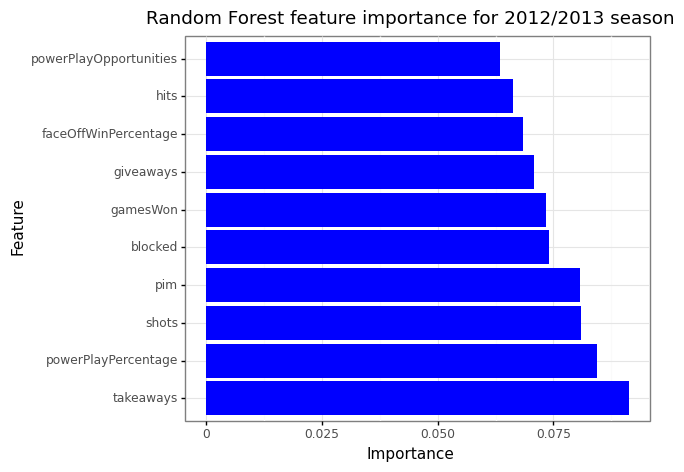

<ggplot: (354725476)>

In [58]:
# top 10 feature importances of the top Random Forest model


rf_features = pd.DataFrame(
    zip(X_train.columns.to_list(), 
        loaded_season_models['2012']['best_models'][3].feature_importances_), 
    columns = ['feature', 'importance'])
top_10_rf = rf_features.sort_values(by='importance', ascending=False)[:10]

# sorting the variable importances for the plot
feature_cat = pd.Categorical(top_10_rf['feature'], categories=top_10_rf['feature'])

# assign to a new column in the DataFrame
top_10_rf = top_10_rf.assign(feature_cat = feature_cat)

plotnine.options.figure_size = (6, 5)

(
ggplot(data = top_10_rf, mapping=aes(x = 'feature_cat', y = 'importance')) + 
    geom_bar(stat = 'identity', fill='blue') + 
    labs(x = "Feature", y = "Importance", title = "Random Forest feature importance for 2012/2013 season") + 
    coord_flip() + 
    theme_bw()
)

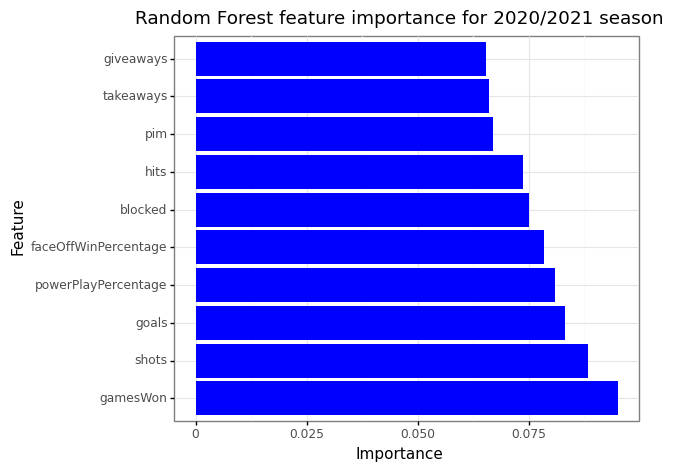

<ggplot: (354486477)>

In [59]:
# top 10 feature importances of the top Random Forest model


rf_features = pd.DataFrame(
    zip(X_train.columns.to_list(), 
        loaded_season_models['2020']['best_models'][3].feature_importances_), 
    columns = ['feature', 'importance'])
top_10_rf = rf_features.sort_values(by='importance', ascending=False)[:10]

# sorting the variable importances for the plot
feature_cat = pd.Categorical(top_10_rf['feature'], categories=top_10_rf['feature'])

# assign to a new column in the DataFrame
top_10_rf = top_10_rf.assign(feature_cat = feature_cat)

plotnine.options.figure_size = (6, 5)

(
ggplot(data = top_10_rf, mapping=aes(x = 'feature_cat', y = 'importance')) + 
    geom_bar(stat = 'identity', fill='blue') + 
    labs(x = "Feature", y = "Importance", title = "Random Forest feature importance for 2020/2021 season") + 
    coord_flip() + 
    theme_bw()
)

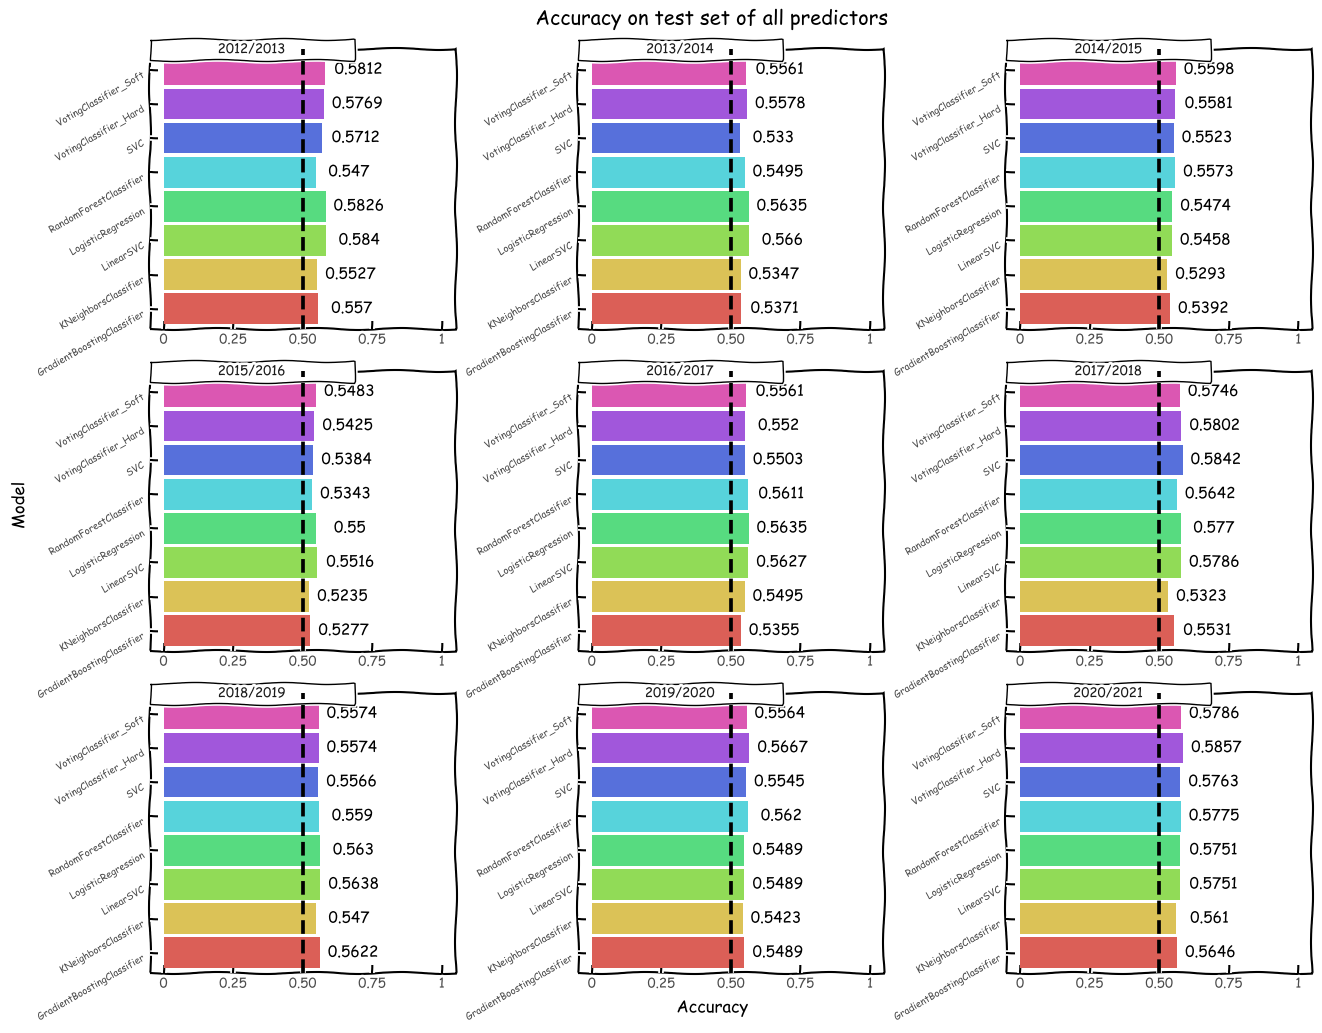

<ggplot: (352682036)>

In [60]:
import functools
def update_mod_names(x):
    x[6] = x[6]+"_Soft"
    x[7] = x[7]+"_Hard"
    return(x)

test_acc_df_list = [pd.DataFrame(zip(update_mod_names([type(mod).__name__ for mod in loaded_season_models[key]['best_models']]),
                          loaded_season_models[key]['test_accuracy'], loaded_season_models[key]['season']), columns = ['model', "accuracy", "season"]) for key in loaded_season_models.keys()]

acc_df = functools.reduce(lambda left, right: 
                                 pd.concat([left, right], axis = 0, ignore_index=True),
                    test_acc_df_list)

# acc_df = pd.DataFrame(zip(update_mod_names([type(mod).__name__ for mod in loaded_season_models['2012']['best_models']]),
#                           loaded_season_models['2012']['test_accuracy'], loaded_season_models['2012']['season']), columns = ['model', "accuracy", "season"])

acc_df = acc_df.sort_values(by=["season", 'accuracy'], ascending=True).assign(accuracy = round(acc_df.accuracy, 4))
# sorting the variable importances for the plot
# feature_cat = pd.Categorical(acc_df[['season', 'model']], 
#                              categories=acc_df[['season', 'model']], 
#                             ordered=True)

# # assign to a new column in the DataFrame
# acc_df = acc_df.assign(season_cat = np.array(feature_cat.categories.to_list())[:,0], 
#                        mod_cat = np.array(feature_cat.categories.to_list())[:,1])
plotnine.options.figure_size = (15, 12)

(
ggplot(data = acc_df, mapping = aes(y = 'accuracy', x = 'model', fill = 'model')) + 
    geom_bar(stat = 'identity') + 
    geom_text(aes(label = "accuracy"), nudge_y = 0.12) +
    theme_xkcd() + 
    lims(y = (0, 1)) + 
    scale_fill_discrete(guide=False) +
    labs(x = "Model", y = "Accuracy", title = "Accuracy on test set of all predictors") +
    geom_hline(yintercept = 0.5, size = 1.5, linetype = 'dashed') + 
    coord_flip() + 
    facet_wrap(" ~ season", scales="free") + 
    theme(subplots_adjust={'wspace': 0.4, 'hspace': 0.15}, 
         axis_text_y=element_text(angle=30, vjust=1, size=7))
)

/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_text : Removed 12 rows containing missing values.


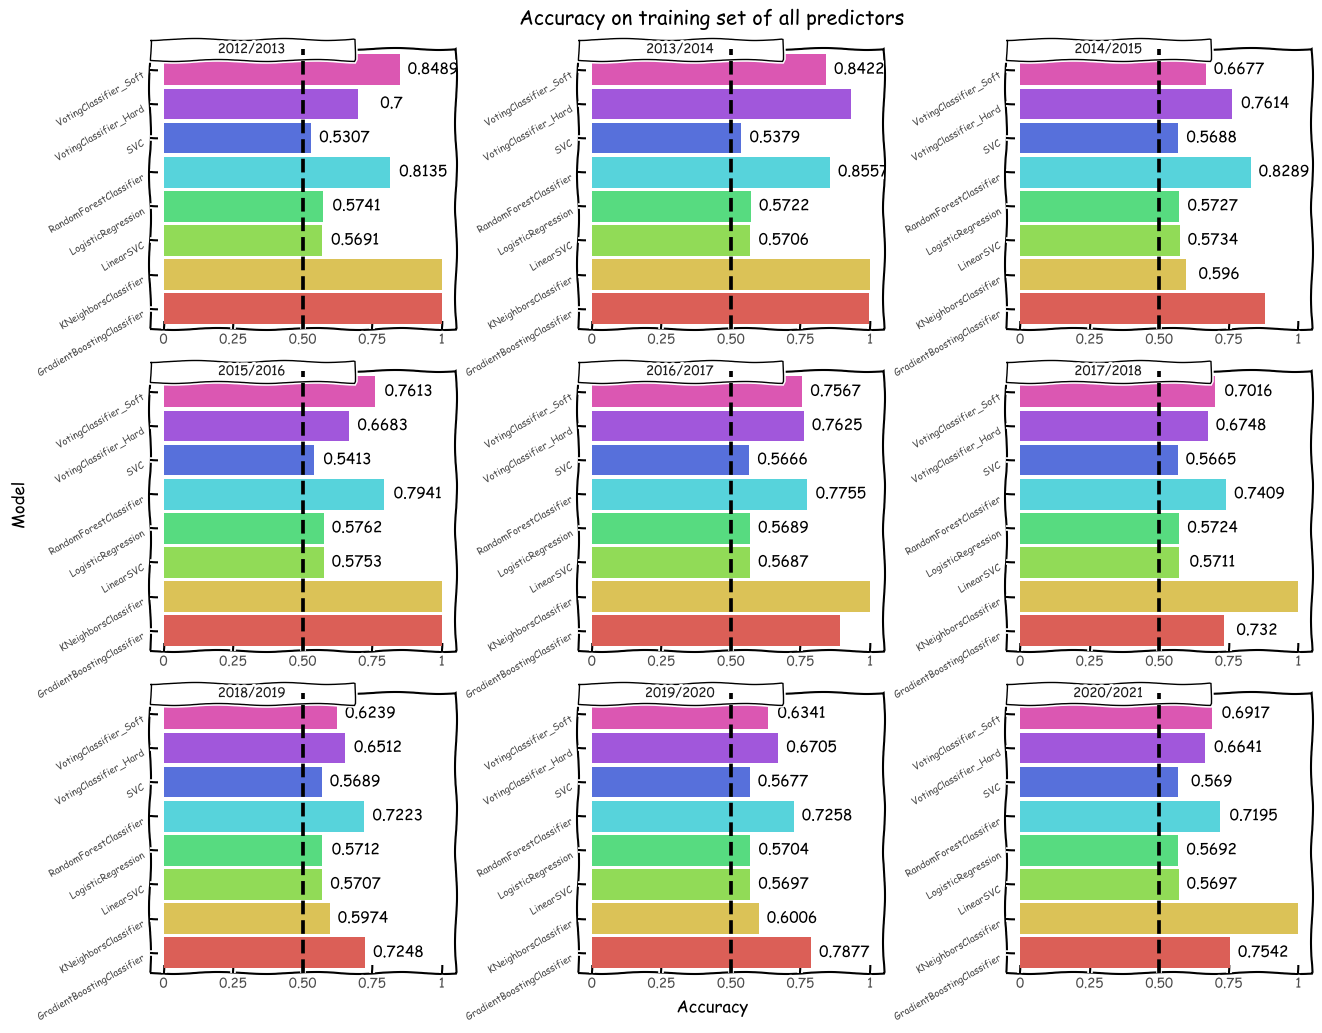

<ggplot: (354407602)>

In [61]:
train_acc_df_list = [pd.DataFrame(zip(update_mod_names([type(mod).__name__ for mod in loaded_season_models[key]['best_models']]),
                          loaded_season_models[key]['train_accuracy'], loaded_season_models[key]['season']), columns = ['model', "accuracy", "season"]) for key in loaded_season_models.keys()]

acc_train_df = functools.reduce(lambda left, right: 
                                 pd.concat([left, right], axis = 0, ignore_index=True),
                    train_acc_df_list)

# acc_df = pd.DataFrame(zip(update_mod_names([type(mod).__name__ for mod in loaded_season_models['2012']['best_models']]),
#                           loaded_season_models['2012']['test_accuracy'], loaded_season_models['2012']['season']), columns = ['model', "accuracy", "season"])

acc_train_df = acc_train_df.sort_values(by=["season", 'accuracy'], ascending=True).assign(accuracy = round(acc_train_df.accuracy, 4))
# sorting the variable importances for the plot
# feature_cat = pd.Categorical(acc_train_df[['season', 'model']], 
#                              categories=acc_train_df[['season', 'model']], 
#                             ordered=True)

# # assign to a new column in the DataFrame
# acc_train_df = acc_train_df.assign(season_cat = np.array(feature_cat.categories.to_list())[:,0], 
#                        mod_cat = np.array(feature_cat.categories.to_list())[:,1])

plotnine.options.figure_size = (15, 12)

(
ggplot(data = acc_train_df, mapping = aes(y = 'accuracy', x = 'model', fill = 'model')) + 
    geom_bar(stat = 'identity') + 
    geom_text(aes(label = "accuracy"), nudge_y = 0.12) +
    theme_xkcd() + 
    lims(y = (0, 1)) + 
    scale_fill_discrete(guide=False) +
    labs(x = "Model", y = "Accuracy", title = "Accuracy on training set of all predictors") +
    geom_hline(yintercept = 0.5, size = 1.5, linetype = 'dashed') + 
    coord_flip() + 
    facet_wrap(" ~ season", scales="free") + 
    theme(subplots_adjust={'wspace': 0.4, 'hspace': 0.15}, 
         axis_text_y=element_text(angle=30, vjust=1, size=7))
)

In [62]:
acc_train_df

,model,accuracy,season
1,SVC,0.5307,2012/2013
2,LinearSVC,0.5691,2012/2013
0,LogisticRegression,0.5741,2012/2013
7,VotingClassifier_Hard,0.7000,2012/2013
3,RandomForestClassifier,0.8135,2012/2013
...,...,...,...
71,VotingClassifier_Hard,0.6641,2020/2021
70,VotingClassifier_Soft,0.6917,2020/2021
67,RandomForestClassifier,0.7195,2020/2021
68,GradientBoostingClassifier,0.7542,2020/2021


In [65]:
acc_df.sort_values('accuracy', ascending=False).head(10)

,model,accuracy,season
71,VotingClassifier_Hard,0.5857,2020/2021
41,SVC,0.5842,2017/2018
2,LinearSVC,0.5840,2012/2013
0,LogisticRegression,0.5826,2012/2013
6,VotingClassifier_Soft,0.5812,2012/2013
47,VotingClassifier_Hard,0.5802,2017/2018
70,VotingClassifier_Soft,0.5786,2020/2021
42,LinearSVC,0.5786,2017/2018
67,RandomForestClassifier,0.5775,2020/2021
40,LogisticRegression,0.5770,2017/2018


In [66]:
preds_2020 = loaded_season_models['2020']['best_models'][7].predict_proba(loaded_season_models['2020']["X_test_transformed"])

ROC:  0.6263791623993136


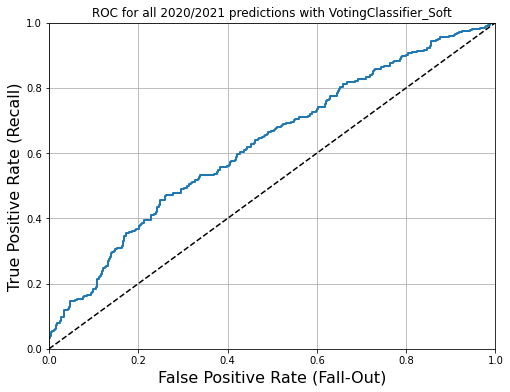

In [67]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown


fpr, tpr, thresholds = roc_curve(loaded_season_models['2020']['y_test'], preds_2020[:, 1])

print("ROC: ", metrics.auc(fpr, tpr))
plt.figure(figsize=(8, 6)); 
plot_roc_curve(fpr, tpr);
plt.title("ROC for all 2020/2021 predictions with VotingClassifier_Soft")
plt.show();

In [76]:
pd.crosstab(loaded_season_models['2020']['y_test'], preds_2020[:, 1]>.63)

accuracy_score(loaded_season_models['2020']['y_test'], preds_2020[:, 1]>.53)

col_0,False,True
homeTeamWin,,
0,384,13
1,407,48


0.5833333333333334

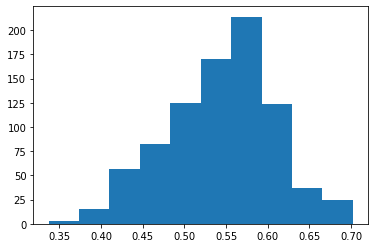

In [77]:
plt.hist(preds_2020[:, 1])

In [82]:
train, test = prediction_df[prediction_df.season.str[0:4].astype(int) < 2020].drop(columns=["gameID", "season", "venue"]), \
                prediction_df[prediction_df.season.str[0:4].astype(int) == 2020].drop(columns=["gameID", "season", "venue"])



In [83]:

train.to_csv("/Users/sawyer/Desktop/data_science_denver/Spring_2021/parallel/homework/assignment_2/nhl_train.csv", index=False)
test.to_csv("/Users/sawyer/Desktop/data_science_denver/Spring_2021/parallel/homework/assignment_2/nhl_test.csv", index=False)